In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import RidgeCV
from sklearn.inspection import permutation_importance
from tqdm import tqdm

# ===================================================
#  LOAD DATA
# ===================================================
rawdata = pd.read_excel("CleanedData.xlsx", sheet_name="RawData", nrows=54)
computeddata = pd.read_excel("CleanedData.xlsx", sheet_name="Computed variables", nrows=54)

print("\n RawData Columns:", rawdata.columns.tolist())
print("\n ComputedData Columns:", computeddata.columns.tolist())


# ===================================================
#  COLUMN 
# ===================================================

questionnaire_items = [
    'Reward_Esteem1', 'Reward_Promotion1 (R)', 'Reward_JobSecurity1 (R)', 'Reward_JobSecurity2 (R)',
    'Reward_Esteem2', 'Reward_Promotion2', 'Reward_Promotion3',
    'Orgz_Commitment1', 'Orgz_Commitment2', 'Orgz_Commitment3 (R)', 'Orgz_Commitment4 (R)',
    'Orgz_Commitment5 (R)', 'Orgz_Commitment6',
    'Relationships_Coworkers1 (R)', 'Relationships_Coworkers2 (R)', 'Relationships_Coworkers3 (R)',
    'Relationships_Supervisors1', 'Relationships_Supervisors2', 'Relationships_Supervisors3 (R)',
    'Relationships_Org1', 'Relationships_Org2', 'Relationships_Org3 (R)',
    'Org_Support1', 'Org_Support2 (R)', 'Org_Support3 (R)', 'Org_Support4', 'Org_Support5 (R)',
    'Org_Support6', 'Org_Support7 (R)', 'Org_Support8',
    'Work_Engagment1', 'Work_Engagment2', 'Work_Engagment3',
    'Work_Addiciton1', 'Work_Addiciton2', 'Work_Addiciton3', 'Work_Addiciton4',
    'Work_Addiciton5', 'Work_Addiciton6', 'Work_Addiciton7',
    'Turnover_Intetntions', 'Job_Satisfaction', 'Role_clarity', 'Work_Life_Balance', 'Stress',
    'MBI_Ex1', 'MBI_Ex2', 'MBI_Ex3', 'MBI_Ex4', 'MBI_PE1', 'MBI_Ex5', 'MBI_PE2',
    'MBI_CY1', 'MBI_CY2', 'MBI_PE3', 'MBI_PE4', 'MBI_PE5', 'MBI_CY3', 'MBI_CY4', 'MBI_CY5', 'MBI_PE6'
]

demo_columns = [
    'Gender', 'Age', 'Ethnicity', 'EducationLevel', 'MaritalStatus', 'Level', 'SportType', 
     'NumberOfAthletes',  'AthletesAges', 'Supervisor', 
    'YrsExperience', 'YrsAtJob', 'ContractType', 'HrsCoaching', 'HrsAdmintrative', 'HrsFluctuation', 
    'ComutePerWeek', 'SickDaysTaken',  'AthletePerformance', 'OrgzFinances',
]

#'SickDaysWanted','SpecificSports','GenderOfAthletes',


sums_columns = [
    'Role_clarity','Work_Life_Balance', 'Reward_Esteem_Sum', 
    'Reward_Promotion_Sum', 'Reward_JobSecurity_Sum',
    'Orgz_Commitment_Sum', 'Relationships_Coworkers_Sum',
    'Relationships_Supervisors_Sum', 'Relationships_OrgCulture_Sum',
    'OrgSupport_Sum', 'WorkEngagment_Sum','AthletePerformance', 'OrgzFinances', 
]
#'WorkAddiction_Sum',

all_feature_columns = list(dict.fromkeys(demo_columns + questionnaire_items))

target_variable = 'Standerdised_IllBeing_Score (Exhaustion, Cynicsm, Turnover intentions, Reduced Job satisfaction, Stress)'


use_features = "sums"  # choices: "all", "demographics", "questionnaire", "sums"

if use_features == "all":
    selected_columns = all_feature_columns
    X_raw_source = rawdata
elif use_features == "demographics":
    selected_columns = demo_columns
    X_raw_source = rawdata
elif use_features == "questionnaire":
    selected_columns = questionnaire_items
    X_raw_source = rawdata
elif use_features == "sums":
    selected_columns = sums_columns
    X_raw_source = computeddata
elif isinstance(use_features, list):
    selected_columns = use_features
    X_raw_source = rawdata
else:
    raise ValueError(f"Unknown choice for use_features: {use_features}")

print(f"\n Using {len(selected_columns)} columns based on setting: {use_features}")



 RawData Columns: ['Gender', 'Age', 'Ethnicity', 'EducationLevel', 'MaritalStatus', 'Level', 'SportType', 'GenderOfAthletes', 'NumberOfAthletes', 'SpecificSports', 'AthletesAges', 'Supervisor', 'YrsExperience', 'YrsAtJob', 'ContractType', 'HrsCoaching', 'HrsAdmintrative', 'HrsFluctuation', 'ComutePerWeek', 'SickDaysTaken', 'SickDaysWanted', 'AthletePerformance', 'OrgzFinances', 'Reward_Esteem1', 'Reward_Promotion1 (R)', 'Reward_JobSecurity1 (R)', 'Reward_JobSecurity2 (R)', 'Reward_Esteem2', 'Reward_Promotion2', 'Reward_Promotion3', 'Orgz_Commitment1', 'Orgz_Commitment2', 'Orgz_Commitment3 (R)', 'Orgz_Commitment4 (R)', 'Orgz_Commitment5 (R)', 'Orgz_Commitment6', 'Relationships_Coworkers1 (R)', 'Relationships_Coworkers2 (R)', 'Relationships_Coworkers3 (R)', 'Relationships_Supervisors1', 'Relationships_Supervisors2', 'Relationships_Supervisors3 (R)', 'Relationships_Org1', 'Relationships_Org2', 'Relationships_Org3 (R)', 'Org_Support1', 'Org_Support2 (R)', 'Org_Support3 (R)', 'Org_Support4

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, LeaveOneOut, cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ------------------------------------------
#  Prepare Data
# ------------------------------------------
merged_data = pd.concat([X_raw_source[selected_columns], computeddata[[target_variable]]], axis=1).dropna()
X = merged_data[selected_columns]
y = merged_data[target_variable]


print(f"\n Final dataset shape: {X.shape} features, {y.shape} target values")

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

# ------------------------------------------
#  Preprocessing + Model Pipeline
# ------------------------------------------
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

ridge_model = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=3)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', ridge_model)
])

# ------------------------------------------
#  Train Model
# ------------------------------------------
pipeline.fit(X, y)

best_alpha = pipeline.named_steps['regressor'].alpha_
print(" Best alpha from RidgeCV:", best_alpha)

# ------------------------------------------
#  Evaluation: LOOCV
# ------------------------------------------
loo = LeaveOneOut()
y_pred_loo = cross_val_predict(pipeline, X, y, cv=loo)
r2_loo = r2_score(y, y_pred_loo)
rmse_loo = np.sqrt(mean_squared_error(y, y_pred_loo))
print(f"\n LOOCV R²: {r2_loo:.3f}")
print(f" LOOCV RMSE: {rmse_loo:.3f}")

from sklearn.linear_model import Ridge

final_ridge = Ridge(alpha=best_alpha)

final_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', final_ridge)
])

final_pipeline.fit(X, y)
print(" Final Ridge model trained on all data with best alpha.")




 Final dataset shape: (39, 13) features, (39,) target values
 Best alpha from RidgeCV: 10.985411419875572

 LOOCV R²: 0.484
 LOOCV RMSE: 2.662
 Final Ridge model trained on all data with best alpha.


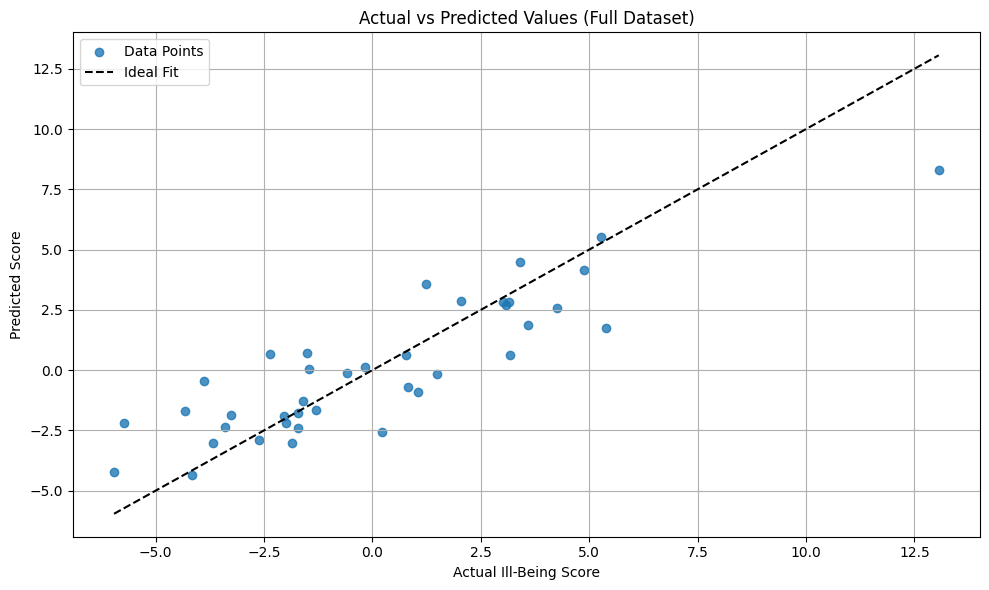


 Top Outliers (by absolute prediction error):
   Participant  Actual  Predicted  Residual
52          53   13.06   8.286244  4.773756
28          29    5.38   1.763494  3.616506
8            9   -5.73  -2.196362  3.533638


In [3]:
# ------------------------------------------
#  Identify Outliers 
# ------------------------------------------

y_pred_full = final_pipeline.predict(X)

X_with_ids = X.copy()
X_with_ids['Participant'] = X_raw_source.loc[X.index, 'Participant #'] 

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_full, label='Data Points', alpha=0.8)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Ideal Fit')
plt.xlabel("Actual Ill-Being Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Values (Full Dataset)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

residuals = np.abs(y - y_pred_full)

outliers_df = pd.DataFrame({
    'Participant': X_with_ids['Participant'],
    'Actual': y.values,
    'Predicted': y_pred_full,
    'Residual': residuals
}).sort_values(by='Residual', ascending=False)

print("\n Top Outliers (by absolute prediction error):")
print(outliers_df.head(3))

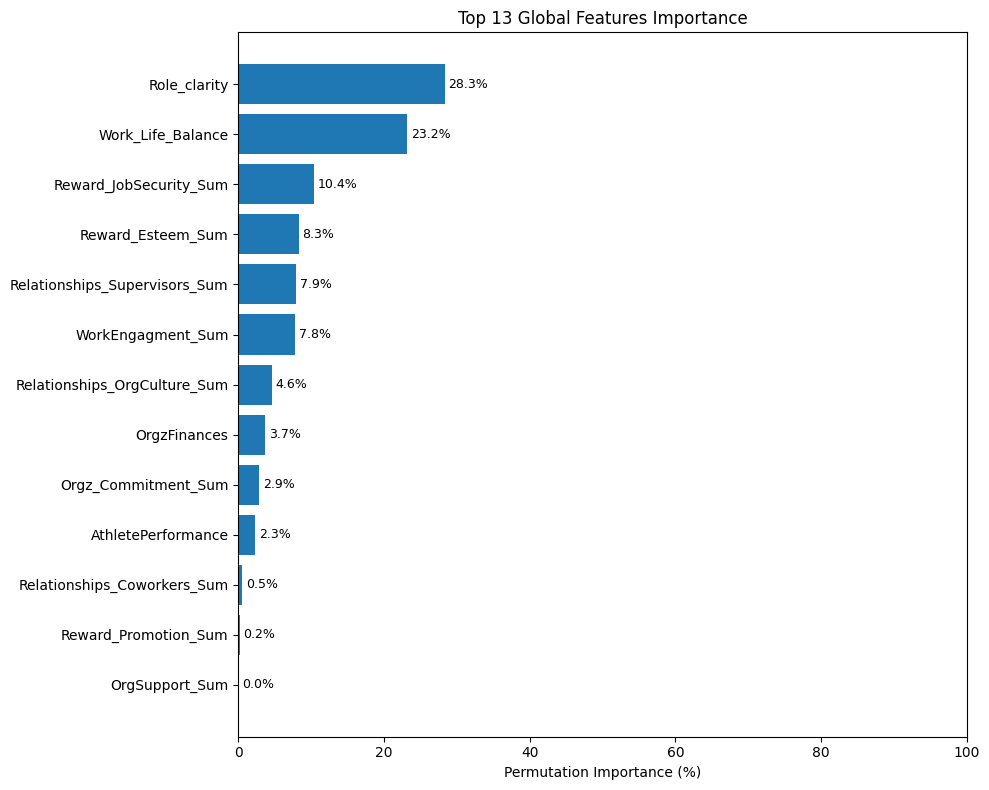

In [4]:
# ------------------------------------------
# Permutation Importance
# ------------------------------------------
X_transformed = pipeline.named_steps['preprocess'].transform(X)

def get_feature_names(column_transformer):
    feature_names = []
    for name, transformer, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
        feature_names.extend(names)
    return [str(f) for f in feature_names]  

fitted_preprocessor = pipeline.named_steps['preprocess']

def get_fitted_feature_names(fitted_preprocessor):
    feature_names = []
    for name, transformer, cols in fitted_preprocessor.transformers_:
        if transformer == 'drop' or transformer is None:
            continue
        fitted_transformer = transformer
        if hasattr(fitted_transformer, 'get_feature_names_out'):
            try:
                names = fitted_transformer.get_feature_names_out(cols)
            except:
                names = cols
        else:
            names = cols
        feature_names.extend([str(n) for n in names])
    return feature_names

feature_names = get_fitted_feature_names(fitted_preprocessor)

result = permutation_importance(
    final_pipeline.named_steps['regressor'],
    X_transformed,
    y,
    n_repeats=20,
    random_state=42
)

importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

top_n = 13
positive_importances = importances_df['importance_mean'].clip(lower=0)

total_importance = positive_importances.sum()
importances_df['importance_pct'] = (positive_importances / total_importance) * 100

importances_df['importance_pct'] = importances_df['importance_pct'].round(1)

top_features = importances_df.sort_values(by='importance_mean', ascending=False).head(top_n).copy()

top_features['importance_pct'] = top_features['importance_pct'].round(1)

# ------------------------------------------
#  Plot Top Features
# ------------------------------------------

top_features = importances_df.head(top_n)

plt.figure(figsize=(10, 8))
bars = plt.barh(
    top_features['feature'][::-1],           
    top_features['importance_pct'][::-1],
    color='tab:blue'
)

for bar, pct in zip(bars, top_features['importance_pct'][::-1]):
    plt.text(
        bar.get_width() + 0.5,                
        bar.get_y() + bar.get_height() / 2,   
        f"{pct:.1f}%",
        va='center',
        fontsize=9
    )

plt.xlim(0, 100) 
plt.xlabel("Permutation Importance (%)")
plt.title(f"Top {top_n} Global Features Importance")
plt.tight_layout()
plt.show()


 [No P#53] Final dataset shape: (38, 13) features, (38,) target values
 [No P#53] Best alpha from RidgeCV: 25.595479226995334
 [No P#53] LOOCV R²: 0.447
 [No P#53] LOOCV RMSE: 2.302
 [No P#53] Final Ridge model trained on filtered data.


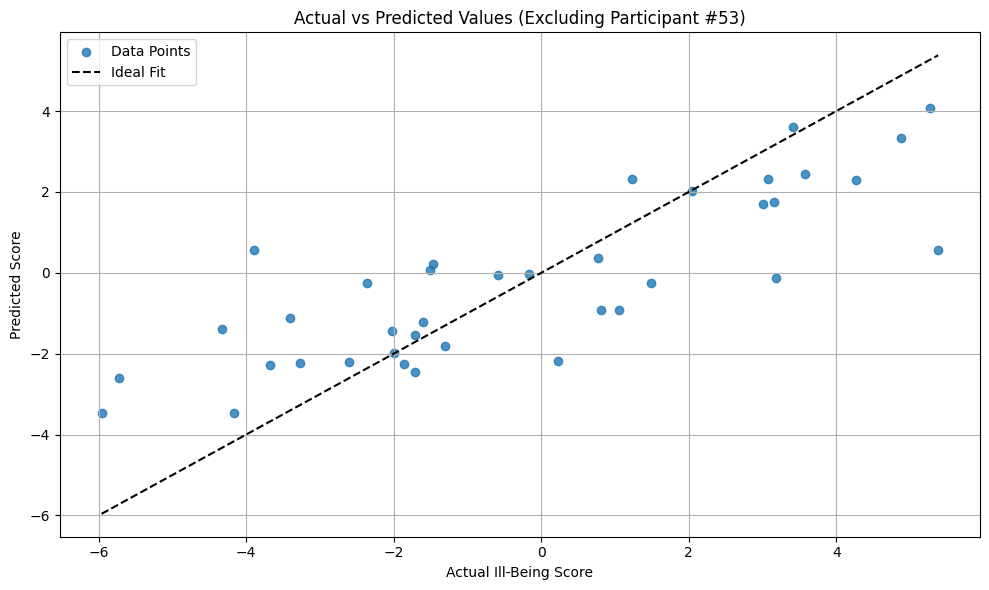


 [No P#53] Top Outliers (by absolute prediction error):
    Participant  Actual  Predicted  Residual
28           24    5.38   0.560063  4.819937
13           11   -3.89   0.561384  4.451384
24           20    3.18  -0.133152  3.313152


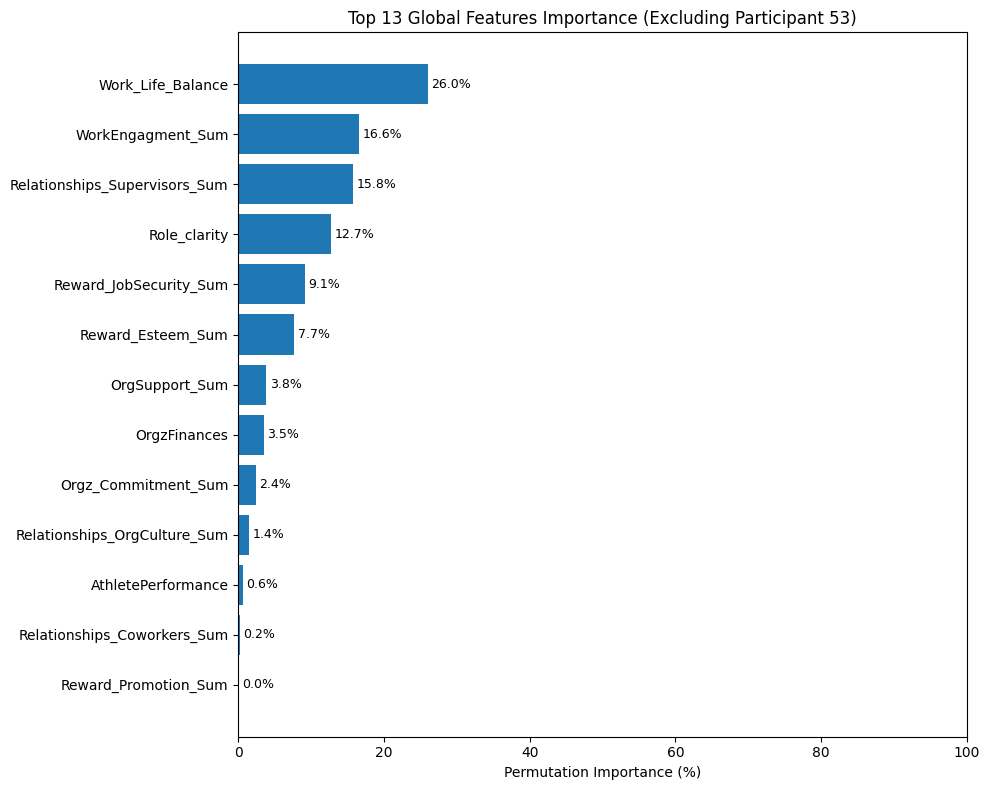

In [5]:
# ===================================================
#  Exclude Participant #53 and re-run the same pipeline
# ===================================================

if "Participant #" in computeddata.columns:
    drop_idx_all = computeddata.index[computeddata["Participant #"] == 53]
else:
    raise KeyError("Column 'Participant #' not found in rawdata. Update the column name if it differs.")

drop_idx = merged_data.index.intersection(drop_idx_all)

merged_data_no53 = merged_data.drop(index=drop_idx)
X_b = merged_data_no53[selected_columns]
y_b = merged_data_no53[target_variable]

print(f"\n [No P#53] Final dataset shape: {X_b.shape} features, {y_b.shape} target values")

categorical_cols_b = X_b.select_dtypes(include='object').columns.tolist()
numeric_cols_b = X_b.select_dtypes(include=np.number).columns.tolist()

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import cross_val_score, LeaveOneOut, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

preprocessor_b = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols_b),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_b)
])

ridge_model_b = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=3)

pipeline_b = Pipeline([
    ('preprocess', preprocessor_b),
    ('regressor', ridge_model_b)
])

pipeline_b.fit(X_b, y_b)
best_alpha_b = pipeline_b.named_steps['regressor'].alpha_
print(" [No P#53] Best alpha from RidgeCV:", best_alpha_b)

loo_b = LeaveOneOut()
y_pred_loo_b = cross_val_predict(pipeline_b, X_b, y_b, cv=loo_b)
r2_loo_b = r2_score(y_b, y_pred_loo_b)
rmse_loo_b = np.sqrt(mean_squared_error(y_b, y_pred_loo_b))
print(f" [No P#53] LOOCV R²: {r2_loo_b:.3f}")
print(f" [No P#53] LOOCV RMSE: {rmse_loo_b:.3f}")

final_ridge_b = Ridge(alpha=best_alpha_b)
final_pipeline_b = Pipeline([
    ('preprocess', preprocessor_b),
    ('regressor', final_ridge_b)
])
final_pipeline_b.fit(X_b, y_b)
print(" [No P#53] Final Ridge model trained on filtered data.")

y_pred_full_b = final_pipeline_b.predict(X_b)

plt.figure(figsize=(10, 6))
plt.scatter(y_b, y_pred_full_b, label='Data Points', alpha=0.8)
plt.plot([y_b.min(), y_b.max()], [y_b.min(), y_b.max()], 'k--', label='Ideal Fit')
plt.xlabel("Actual Ill-Being Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Values (Excluding Participant #53)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if "Participant #" in rawdata.columns:
    participant_ids_b = rawdata.loc[X_b.index, "Participant #"]
else:
    participant_ids_b = pd.Series(np.arange(1, len(X_b)+1), index=X_b.index, name='Participant')

residuals_b = np.abs(y_b - y_pred_full_b)
outliers_df_b = pd.DataFrame({
    'Participant': participant_ids_b,
    'Actual': y_b.values,
    'Predicted': y_pred_full_b,
    'Residual': residuals_b
}).sort_values(by='Residual', ascending=False)

print("\n [No P#53] Top Outliers (by absolute prediction error):")
print(outliers_df_b.head(3))

X_transformed_b = pipeline_b.named_steps['preprocess'].transform(X_b)

fitted_preprocessor_b = pipeline_b.named_steps['preprocess']
feature_names_b = get_fitted_feature_names(fitted_preprocessor_b)

result_b = permutation_importance(
    final_pipeline_b.named_steps['regressor'],
    X_transformed_b,
    y_b,
    n_repeats=20,
    random_state=42
)

importances_df_b = pd.DataFrame({
    'feature': feature_names_b,
    'importance_mean': result_b.importances_mean,
    'importance_std': result_b.importances_std
}).sort_values(by='importance_mean', ascending=False)

positive_importances_b = importances_df_b['importance_mean'].clip(lower=0)
total_importance_b = positive_importances_b.sum() if positive_importances_b.sum() > 0 else 1.0
importances_df_b['importance_pct'] = (positive_importances_b / total_importance_b) * 100
importances_df_b['importance_pct'] = importances_df_b['importance_pct'].round(1)

top_n_b = 13
top_features_b = importances_df_b.head(top_n_b).copy()

plt.figure(figsize=(10, 8))
bars_b = plt.barh(
    top_features_b['feature'][::-1],
    top_features_b['importance_pct'][::-1],
    color='tab:blue'
)

for bar, pct in zip(bars_b, top_features_b['importance_pct'][::-1]):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{pct:.1f}%",
        va='center',
        fontsize=9
    )

plt.xlim(0, 100)
plt.xlabel("Permutation Importance (%)")
plt.title(f"Top {top_n_b} Global Features Importance (Excluding Participant 53)")
plt.tight_layout()
plt.show()


In [6]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=3, shuffle=True, random_state=42)
seen_test_indices = []
fold_sizes = []

for i, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"Fold {i+1}:")
    
    overlap = set(test_idx).intersection(*seen_test_indices) if seen_test_indices else set()
    print(f"  Overlap with previous folds: {len(overlap)}")
    seen_test_indices.append(set(test_idx))
    
    fold_sizes.append(len(test_idx))

print("\nFold sizes:", fold_sizes)
print("Are all folds the same size?", len(set(fold_sizes)) == 1)

Fold 1:
  Overlap with previous folds: 0
Fold 2:
  Overlap with previous folds: 0
Fold 3:
  Overlap with previous folds: 0

Fold sizes: [13, 13, 13]
Are all folds the same size? True



Feature: Role_clarity
  (3) Old Participant IDs : [22, 41, 50]
  (7) Young Participant IDs : [5, 9, 12, 19, 27, 28, 31]

Feature: Work_Life_Balance
  (6) Old Participant IDs : [35, 41, 45, 46, 49, 50]
  (13) Young Participant IDs : [2, 3, 5, 9, 12, 16, 19, 20, 24, 27, 31, 32, 36]

Feature: Reward_JobSecurity_Sum
  (5) Old Participant IDs : [21, 37, 45, 49, 50]
  (11) Young Participant IDs : [5, 6, 14, 17, 20, 28, 31, 32, 36, 38, 44]

Feature: Reward_Esteem_Sum
  (3) Old Participant IDs : [21, 46, 50]
  (5) Young Participant IDs : [5, 28, 29, 31, 38]

Feature: Relationships_Supervisors_Sum
  (3) Old Participant IDs : [23, 41, 46]
  (8) Young Participant IDs : [3, 5, 16, 17, 20, 28, 29, 38]

Feature: WorkEngagment_Sum
  (8) Old Participant IDs : [23, 35, 37, 41, 45, 46, 49, 50]
  (9) Young Participant IDs : [5, 9, 12, 16, 19, 25, 27, 28, 36]

Feature: Relationships_OrgCulture_Sum
  (6) Old Participant IDs : [37, 41, 45, 46, 49, 50]
  (7) Young Participant IDs : [5, 12, 17, 27, 28, 29, 3

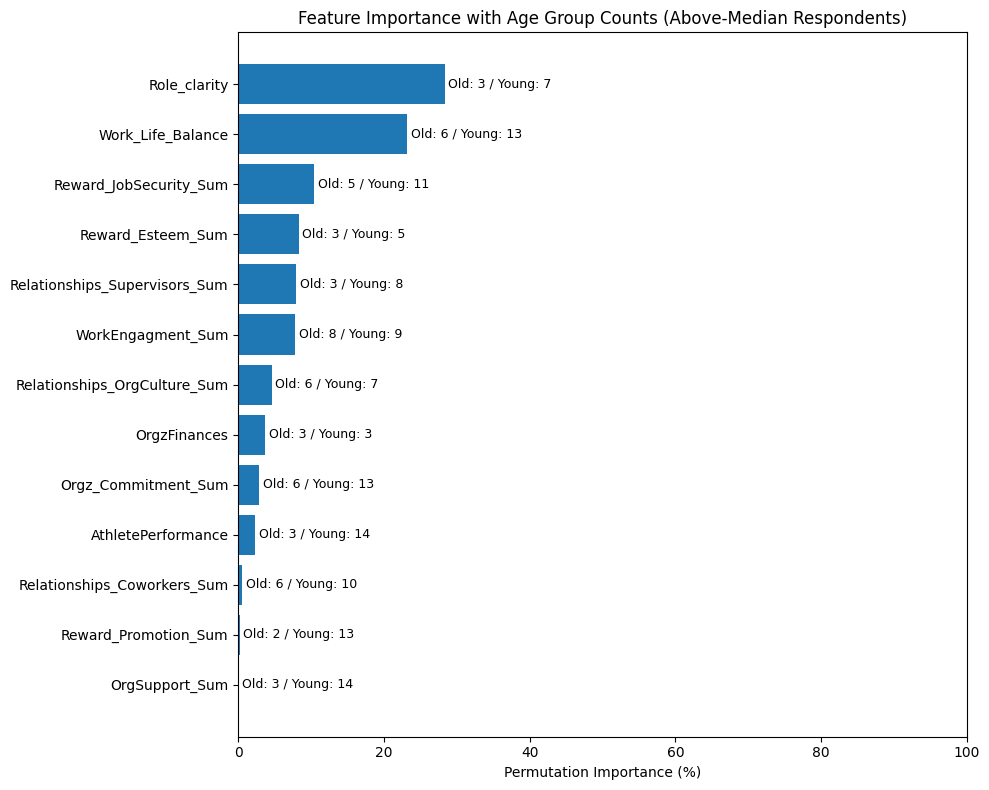

In [7]:
# -----------------------------
# Prep: AgeGroup + IDs
# -----------------------------
X_with_agegroup = X.copy()
X_with_agegroup['Age'] = X_raw_source.loc[X_with_agegroup.index, 'Age']

def map_age_group(age_str):
    if age_str in ['25-34', '35-44']:
        return 'Young'
    elif age_str in ['45-54', '55-64']:
        return 'Old'
    else:
        return 'Unknown'

X_with_agegroup['AgeGroup'] = X_with_agegroup['Age'].apply(map_age_group)

X_with_ids = X.copy()
X_with_ids['Participant'] = X_raw_source.loc[X.index, 'Participant #']
X_with_ids['AgeGroup'] = X_with_agegroup['AgeGroup']

# -----------------------------
# Top features
# -----------------------------
top_n = 15
top_features = importances_df.head(top_n).copy()

# -----------------------------
# Build labels + collect IDs
# -----------------------------
agegroup_labels = []
old_ids_col = []
young_ids_col = []

for feature in top_features['feature']:
    if feature in X.columns:
        
        median_val = X[feature].median()
        above_median = X[feature] > median_val

        counts = X_with_agegroup.loc[above_median, 'AgeGroup'].value_counts()
        parts = [f"{group}: {count}" for group, count in counts.sort_index().items()]
        label = " / ".join(parts) if len(parts) > 0 else "N/A"

        old_ids = X_with_ids.loc[above_median & (X_with_ids['AgeGroup'] == 'Old'), 'Participant'].tolist()
        young_ids = X_with_ids.loc[above_median & (X_with_ids['AgeGroup'] == 'Young'), 'Participant'].tolist()

        print(f"\nFeature: {feature}")
        print(f"  ({len(old_ids)}) Old Participant IDs : {old_ids}")
        print(f"  ({len(young_ids)}) Young Participant IDs : {young_ids}")

    else:
        label = "N/A"
        old_ids = []
        young_ids = []

    agegroup_labels.append(label)
    old_ids_col.append(old_ids)
    young_ids_col.append(young_ids)

top_features['agegroup_label'] = agegroup_labels
top_features['old_ids'] = old_ids_col
top_features['young_ids'] = young_ids_col

# -----------------------------
# Plot 
# -----------------------------
plt.figure(figsize=(10, 8))
bars = plt.barh(
    top_features['feature'][::-1],            
    top_features['importance_pct'][::-1],     
    color='tab:blue'
)

for bar, label in zip(bars, top_features['agegroup_label'][::-1]):
    plt.text(
        bar.get_width() + 0.5,                
        bar.get_y() + bar.get_height() / 2, 
        label,
        va='center',
        fontsize=9,
        color='black'
    )

plt.xlim(0, 100) 
plt.xlabel("Permutation Importance (%)")
plt.title("Feature Importance with Age Group Counts (Above-Median Respondents)")
plt.tight_layout()
plt.show()

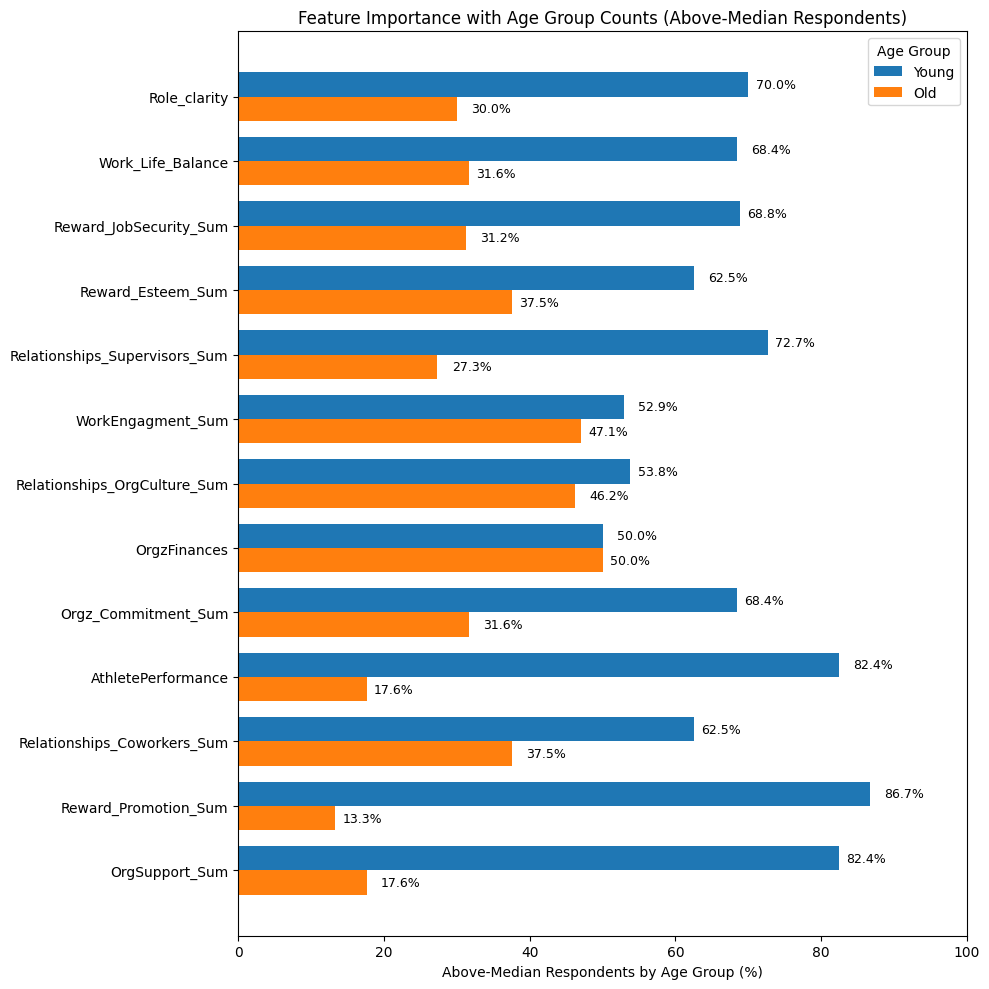

In [8]:
import matplotlib.pyplot as plt
import numpy as np

X_with_agegroup = X.copy()
X_with_agegroup['Age'] = X_raw_source.loc[X_with_agegroup.index, 'Age']

def map_age_group(age_str):
    if age_str in ['25-34', '35-44']:
        return 'Young'
    elif age_str in ['45-54', '55-64']:
        return 'Old'
    else:
        return 'Unknown'

X_with_agegroup['AgeGroup'] = X_with_agegroup['Age'].apply(map_age_group)

top_n = 15
top_features = importances_df.head(top_n).copy()
feature_names = top_features['feature'].tolist()
age_groups = ['Young', 'Old'] 

percentage_matrix = np.zeros((len(feature_names), len(age_groups)))

for i, feat in enumerate(feature_names):
    if feat in X.columns:
        median_val = X[feat].median()
        high_vals = X[feat] > median_val
        counts = X_with_agegroup.loc[high_vals, 'AgeGroup'].value_counts(normalize=True) * 100
        for j, group in enumerate(age_groups):
            percentage_matrix[i, j] = round(counts.get(group, 0), 1)
    else:
        percentage_matrix[i, :] = np.nan

y_pos = np.arange(len(feature_names)) * 1.2
height = 0.45

plt.figure(figsize=(10, 10))
for j, group in enumerate(age_groups):
    plt.barh(
        y_pos + j * height,
        percentage_matrix[:, j],
        height=height,
        label=group
    )

for i in range(len(feature_names)):
    for j in range(len(age_groups)):
        val = percentage_matrix[i, j]
        if val > 0:
            offset = 0.5 + (0.5 if (i + j) % 2 == 0 else 1.5)
            plt.text(
                val + offset,
                y_pos[i] + j * height,
                f"{val:.1f}%",
                va='center',
                fontsize=9
            )

plt.xlim(0, 100)
plt.yticks(y_pos + height * 0.5, feature_names)
plt.xlabel("Above-Median Respondents by Age Group (%)")
plt.title("Feature Importance with Age Group Counts (Above-Median Respondents)")
plt.legend(title="Age Group")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



Feature: Role_clarity
  National above-median IDs (4): [9, 19, 27, 28]
  International above-median IDs (4): [12, 22, 31, 50]
  Both above-median IDs (2): [5, 41]
  Other above-median IDs (0): []

Feature: Work_Life_Balance
  National above-median IDs (8): [2, 3, 9, 19, 20, 27, 36, 46]
  International above-median IDs (4): [12, 31, 45, 50]
  Both above-median IDs (7): [5, 16, 24, 32, 35, 41, 49]
  Other above-median IDs (0): []

Feature: Reward_JobSecurity_Sum
  National above-median IDs (7): [6, 14, 20, 28, 36, 37, 38]
  International above-median IDs (6): [17, 21, 31, 44, 45, 50]
  Both above-median IDs (3): [5, 32, 49]
  Other above-median IDs (0): []

Feature: Reward_Esteem_Sum
  National above-median IDs (3): [28, 38, 46]
  International above-median IDs (3): [21, 31, 50]
  Both above-median IDs (2): [5, 29]
  Other above-median IDs (0): []

Feature: Relationships_Supervisors_Sum
  National above-median IDs (6): [3, 20, 23, 28, 38, 46]
  International above-median IDs (1): [17]
 

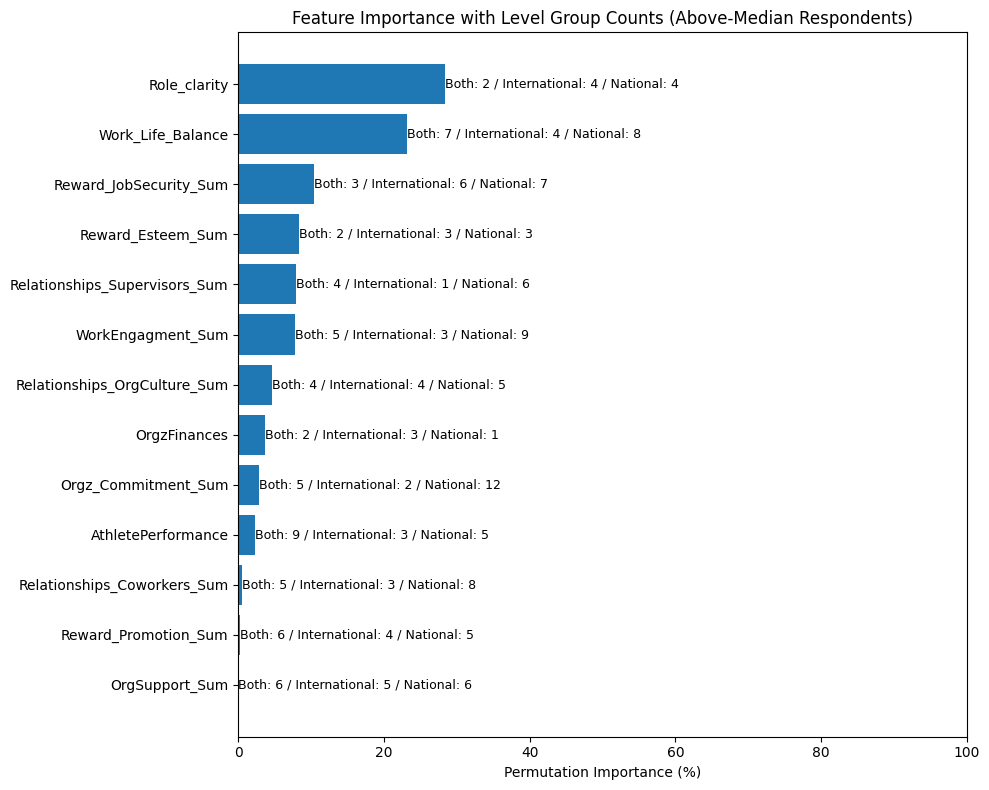

In [9]:
X_with_level = X.copy()
X_with_level['Level'] = X_raw_source.loc[X_with_level.index, 'Level']

def map_level_group(level_str):

    parts = [x.strip() for x in level_str.split(',')]
    has_national = 'National Competitions' in parts or 'Professional Leagues or Tours' in parts
    has_international = 'International Competitions' in parts
    has_others = 'Other' in parts

    if has_national and has_international:
        return 'Both'
    elif has_national:
        return 'National'
    elif has_international:
        return 'International'
    elif has_others:
        return 'Other'

X_with_level['LevelGroup'] = X_with_level['Level'].apply(map_level_group)

X_with_ids_lvl = X.copy()
X_with_ids_lvl['Participant'] = X_raw_source.loc[X.index, 'Participant #']
X_with_ids_lvl['LevelGroup'] = X_with_level['LevelGroup']

level_groups = ['National', 'International', 'Both', 'Other']

top_n = 15
top_features = importances_df.head(top_n).copy()

level_labels = []

ids_cols = {g: [] for g in level_groups}

for feat in top_features['feature']:
    if feat in X.columns:
        median_val = X[feat].median()
        high_vals = X[feat] > median_val 

        level_counts = X_with_level.loc[high_vals, 'LevelGroup'].value_counts()
        label_parts = [f"{grp}: {level_counts.get(grp, 0)}" for grp in sorted(level_counts.index)]
        label = " / ".join(label_parts) if len(level_counts) else "N/A"

        ids_by_group = {}
        for grp in level_groups:
            ids_list = X_with_ids_lvl.loc[high_vals & (X_with_ids_lvl['LevelGroup'] == grp), 'Participant'].tolist()
            ids_by_group[grp] = ids_list
            ids_cols[grp].append(ids_list)

        print(f"\nFeature: {feat}")
        for grp in level_groups:
            print(f"  {grp} above-median IDs ({len(ids_by_group[grp])}): {ids_by_group[grp]}")

    else:
        label = "N/A"
        for grp in level_groups:
            ids_cols[grp].append([])

    level_labels.append(label)

top_features['level_label'] = level_labels
for grp in level_groups:
    top_features[f'ids_{grp}'] = ids_cols[grp]

plt.figure(figsize=(10, 8))
bars = plt.barh(
    top_features['feature'][::-1],
    top_features['importance_pct'][::-1],
    color='tab:blue'
)

for bar, label in zip(bars, top_features['level_label'][::-1]):
    plt.text(
        bar.get_width() + 0.001,
        bar.get_y() + bar.get_height() / 2,
        label,
        va='center',
        fontsize=9,
        color='black'
    )

plt.xlim(0, 100)
plt.xlabel("Permutation Importance (%)")
plt.title("Feature Importance with Level Group Counts (Above-Median Respondents)")
plt.tight_layout()
plt.show()

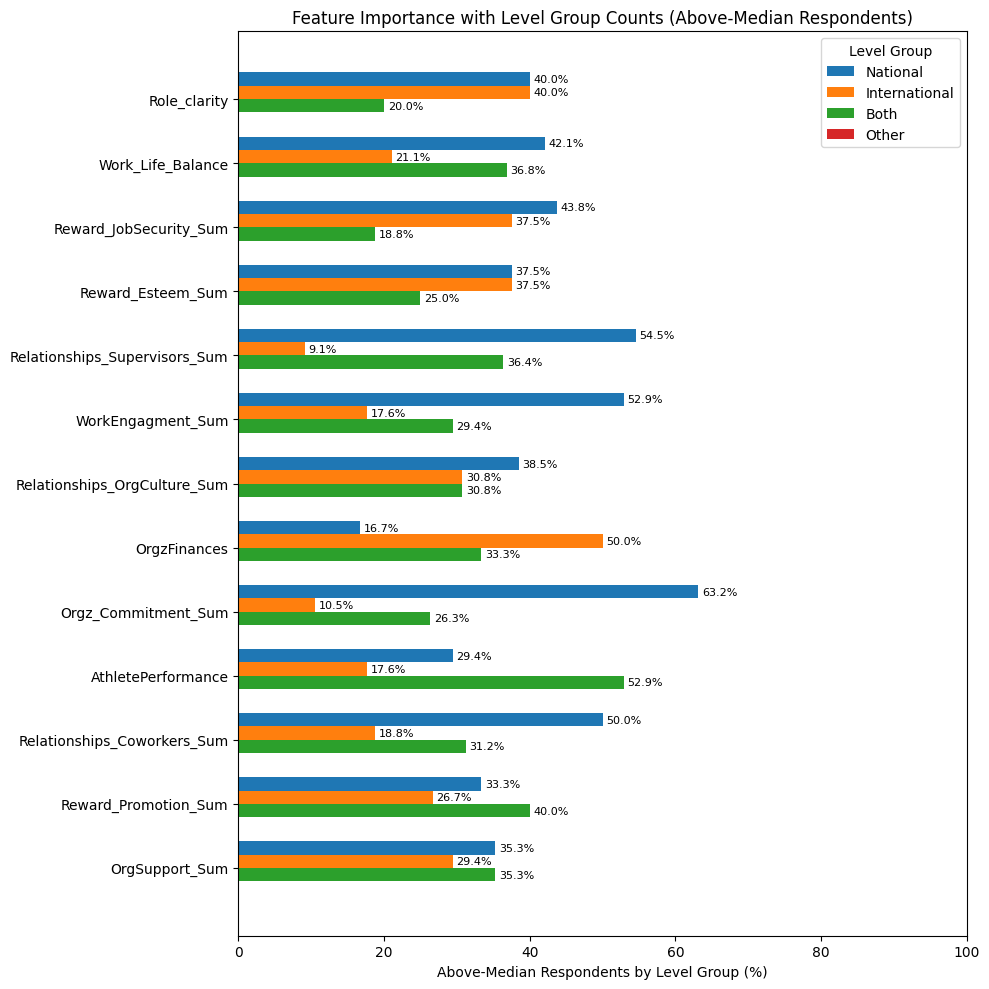

In [10]:
import matplotlib.pyplot as plt
import numpy as np

level_groups = ['National', 'International', 'Both', 'Other']
feature_names = top_features['feature'].tolist()
feature_labels = top_features['feature']

percentage_matrix = []

for feat in feature_names:
    if feat in X.columns:
        median_val = X[feat].median()
        high_vals = X[feat] > median_val

        group_counts = X_with_level.loc[high_vals, 'LevelGroup'].value_counts()
        total = group_counts.sum()
        row = [(group_counts.get(group, 0) / total) * 100 if total > 0 else 0 for group in level_groups]
    else:
        row = [0] * len(level_groups)
    percentage_matrix.append(row)

percentage_matrix = np.array(percentage_matrix)


y_pos = np.arange(len(feature_names)) * 1.2  
height = 0.25 

plt.figure(figsize=(10, 10))
for i, group in enumerate(level_groups):
    plt.barh(
        y_pos + i * height,
        percentage_matrix[:, i],
        height=height,
        label=group
    )

for i in range(len(feature_names)):
    for j in range(len(level_groups)):
        val = percentage_matrix[i, j]
        if val > 0:
            offset = 0.5  
            plt.text(
                val + offset,                   
                y_pos[i] + j * height,                   
                f"{val:.1f}%",
                ha='left',
                va='center',
                fontsize=8,
                color='black'
            )

plt.xlim(0, 100)
plt.yticks(y_pos + height * (len(level_groups) - 1) / 2, feature_labels)
plt.xlabel("Above-Median Respondents by Level Group (%)")
plt.title("Feature Importance with Level Group Counts (Above-Median Respondents)")
plt.legend(title="Level Group")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


Feature: Role_clarity
  25-34 above-median IDs (3): [19, 27, 31]
  35-44 above-median IDs (4): [5, 9, 12, 28]
  45-54 above-median IDs (0): []
  55-64 above-median IDs (3): [22, 41, 50]

Feature: Work_Life_Balance
  25-34 above-median IDs (6): [2, 3, 19, 27, 31, 32]
  35-44 above-median IDs (7): [5, 9, 12, 16, 20, 24, 36]
  45-54 above-median IDs (2): [45, 46]
  55-64 above-median IDs (4): [35, 41, 49, 50]

Feature: Reward_JobSecurity_Sum
  25-34 above-median IDs (4): [6, 14, 31, 32]
  35-44 above-median IDs (7): [5, 17, 20, 28, 36, 38, 44]
  45-54 above-median IDs (3): [21, 37, 45]
  55-64 above-median IDs (2): [49, 50]

Feature: Reward_Esteem_Sum
  25-34 above-median IDs (2): [29, 31]
  35-44 above-median IDs (3): [5, 28, 38]
  45-54 above-median IDs (2): [21, 46]
  55-64 above-median IDs (1): [50]

Feature: Relationships_Supervisors_Sum
  25-34 above-median IDs (2): [3, 29]
  35-44 above-median IDs (6): [5, 16, 17, 20, 28, 38]
  45-54 above-median IDs (2): [23, 46]
  55-64 above-me

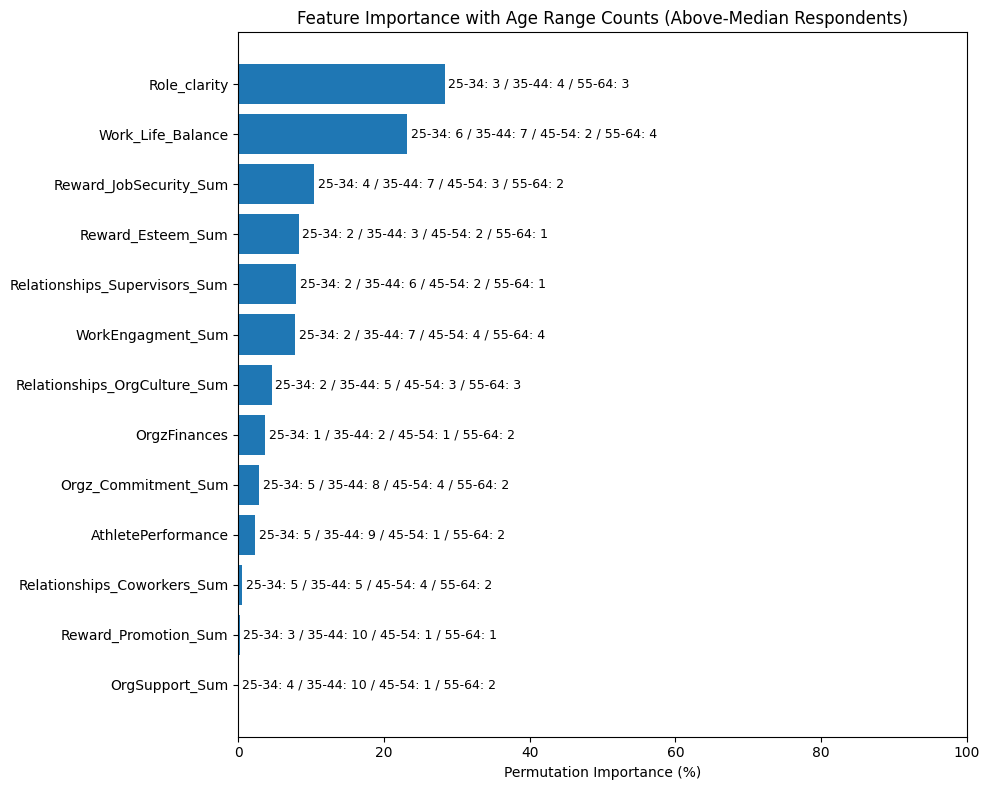

In [11]:
X_with_age = X.copy()
X_with_age['Age'] = X_raw_source.loc[X.index, 'Age']

X_with_ids_age = X.copy()
X_with_ids_age['Participant'] = X_raw_source.loc[X.index, 'Participant #']
X_with_ids_age['Age'] = X_with_age['Age']

age_categories = sorted(X_with_age['Age'].dropna().unique().tolist())

top_n = 15
top_features_age = importances_df.head(top_n).copy()

age_labels = []
ids_by_age_cols = {age: [] for age in age_categories}

for feat in top_features_age['feature']:
    if feat in X.columns:
        med = X[feat].median()
        high_vals = X[feat] > med

        age_counts = X_with_age.loc[high_vals, 'Age'].value_counts()
        label_parts = [f"{age}: {age_counts.get(age, 0)}" for age in age_categories if age_counts.get(age, 0) > 0]
        label = " / ".join(label_parts) if label_parts else "N/A"

        ids_this_feat = {}
        for age in age_categories:
            ids_list = X_with_ids_age.loc[high_vals & (X_with_ids_age['Age'] == age), 'Participant'].tolist()
            ids_this_feat[age] = ids_list
            ids_by_age_cols[age].append(ids_list)

        print(f"\nFeature: {feat}")
        for age in age_categories:
            print(f"  {age} above-median IDs ({len(ids_this_feat[age])}): {ids_this_feat[age]}")
    else:
        label = "N/A"
        for age in age_categories:
            ids_by_age_cols[age].append([])

    age_labels.append(label)

top_features_age['age_label'] = age_labels
for age in age_categories:
    safe_col = f'ids_age_{str(age).lower().replace(" ", "_").replace("+", "plus").replace("/", "_")}'
    top_features_age[safe_col] = ids_by_age_cols[age]

plt.figure(figsize=(10, 8))
bars = plt.barh(
    top_features_age['feature'][::-1],
    top_features_age['importance_pct'][::-1],
    color='tab:blue'
)

for bar, label in zip(bars, top_features_age['age_label'][::-1]):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        label,
        va='center',
        fontsize=9,
        color='black'
    )

plt.xlim(0, 100)
plt.xlabel("Permutation Importance (%)")
plt.title("Feature Importance with Age Range Counts (Above-Median Respondents)")
plt.tight_layout()
plt.show()

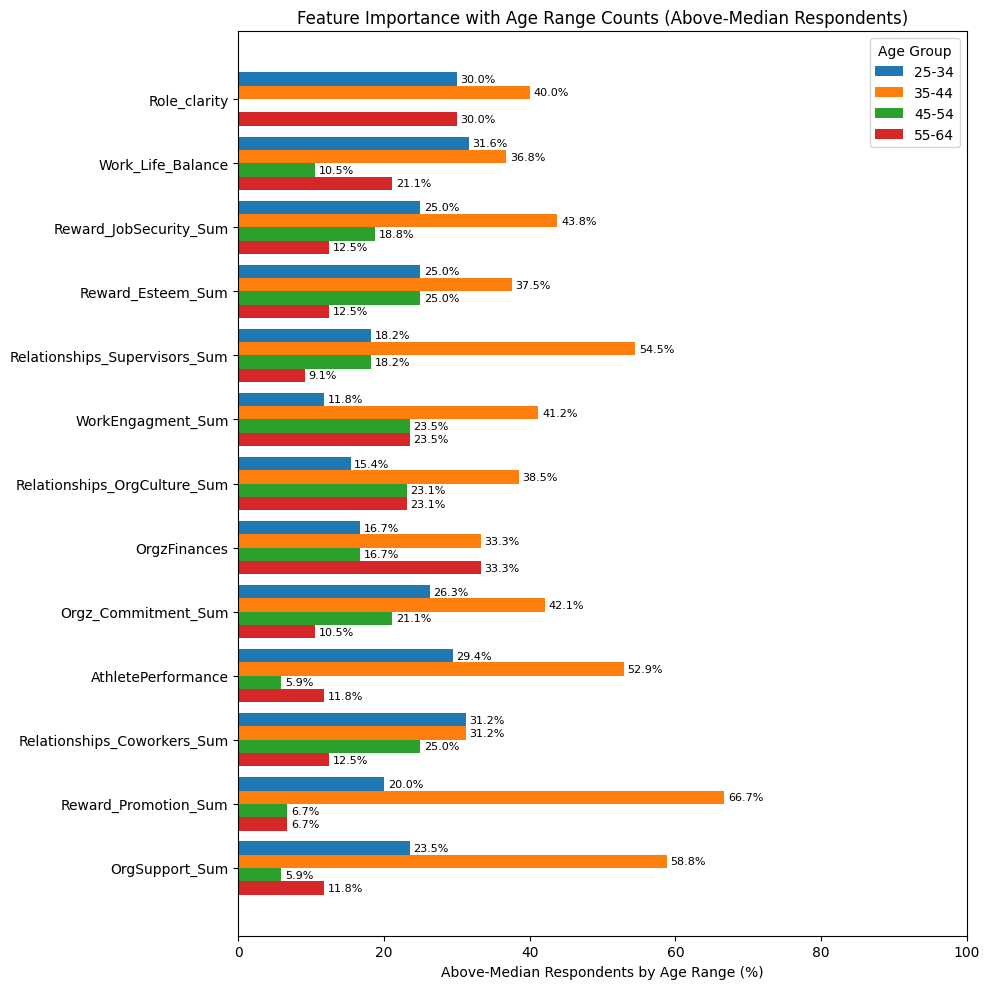

In [12]:
import matplotlib.pyplot as plt
import numpy as np

X_with_age = X.copy()
X_with_age['Age'] = X_raw_source.loc[X.index, 'Age']

top_n = 15
top_features_age = importances_df.head(top_n).copy()
feature_names = top_features_age['feature'].tolist()

age_groups = sorted(X_with_age['Age'].dropna().unique())

percentage_matrix = np.zeros((len(feature_names), len(age_groups)))

for i, feat in enumerate(feature_names):
    if feat in X.columns:
        median_val = X[feat].median()
        high_vals = X[feat] > median_val
        age_counts = X_with_age.loc[high_vals, 'Age'].value_counts(normalize=True) * 100
        for j, age in enumerate(age_groups):
            percentage_matrix[i, j] = round(age_counts.get(age, 0), 1)
    else:
        percentage_matrix[i, :] = np.nan

y_pos = np.arange(len(feature_names)) * 1.2  
height = 0.25 

plt.figure(figsize=(10, 10))
for j, age in enumerate(age_groups):
    plt.barh(
        y_pos + j * height,
        percentage_matrix[:, j],
        height=height,
        label=age
    )

for i in range(len(feature_names)):
    for j in range(len(age_groups)):
        val = percentage_matrix[i, j]
        if val > 0:
            offset = 0.5 
            plt.text(
                val + offset,                        
                y_pos[i] + j * height,                 
                f"{val:.1f}%",
                ha='left',
                va='center',
                fontsize=8,
                color='black'
            )

plt.xlim(0, 100)
plt.yticks(y_pos + height * (len(age_groups) - 1) / 2, feature_names)
plt.xlabel("Above-Median Respondents by Age Range (%)")
plt.title("Feature Importance with Age Range Counts (Above-Median Respondents)")
plt.legend(title="Age Group")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


Counts by JobGroup:
 JobGroup
Less than 5    23
More than 5    16
Name: count, dtype: int64


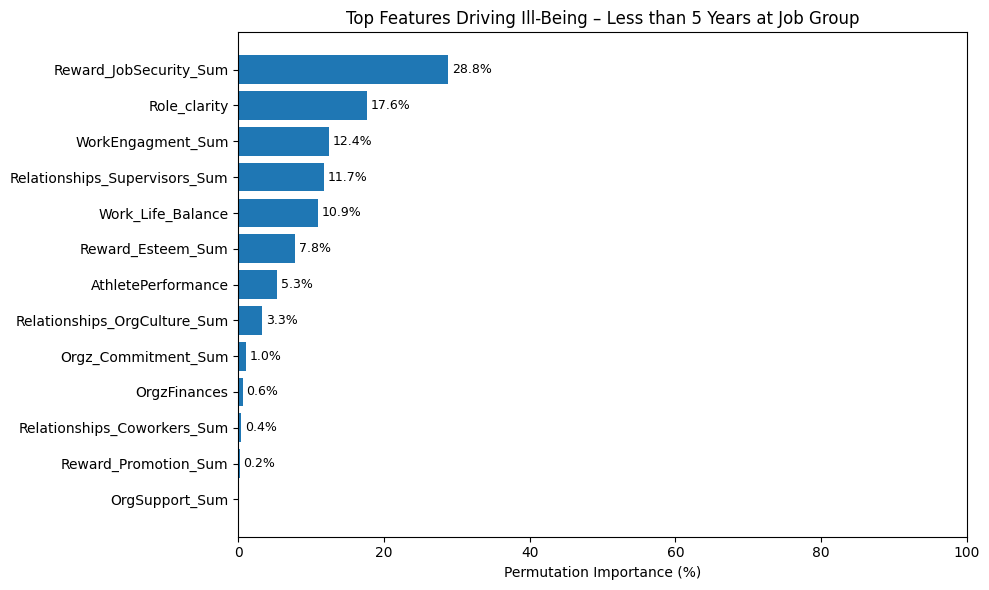

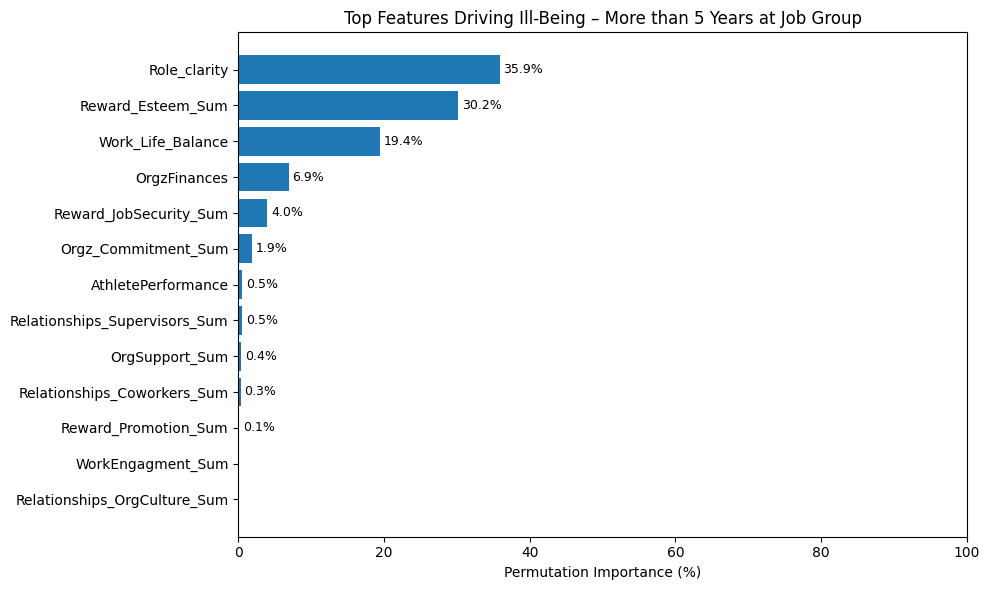

In [13]:

X_with_job = X.copy()
X_with_job['YrsAtJob'] = X_raw_source.loc[X_with_job.index, 'YrsAtJob']


def map_job_group(exp_str):
    if exp_str in ['Less than 1 year', '1–2 years', '2–5 years']:
        return 'Less than 5'
    elif exp_str in ['5–10 years', '10–20 years', '20-30 years']:
        return 'More than 5'
    else:
        return 'Unknown'

X_with_job['JobGroup'] = X_with_job['YrsAtJob'].apply(map_job_group)


job_group_counts = X_with_job['JobGroup'].value_counts()
print("\nCounts by JobGroup:\n", job_group_counts)
      
      
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

group_results = {}

for group in ['Less than 5', 'More than 5']:
    idx = X_with_job['JobGroup'] == group
    X_group = X.loc[idx]
    y_group = y.loc[idx]

    if len(X_group) < 5:
        print(f"⚠️ Skipping {group} group due to too few samples ({len(X_group)})")
        continue

    group_pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('regressor', RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5))
    ])
    group_pipeline.fit(X_group, y_group)

    X_transformed_group = group_pipeline.named_steps['preprocess'].transform(X_group)

    group_feature_names = []
    group_feature_names.extend(numeric_cols)
    cat_transformer = group_pipeline.named_steps['preprocess'].named_transformers_.get('cat')
    if categorical_cols and cat_transformer and hasattr(cat_transformer, 'get_feature_names_out'):
        group_feature_names.extend(list(cat_transformer.get_feature_names_out(categorical_cols)))

    if len(group_feature_names) != X_transformed_group.shape[1]:
        group_feature_names = [f"feature_{i}" for i in range(X_transformed_group.shape[1])]

    perm_result = permutation_importance(
        group_pipeline.named_steps['regressor'],
        X_transformed_group,
        y_group,
        n_repeats=20,
        random_state=42
    )

    group_importance_df = pd.DataFrame({
        'feature': group_feature_names,
        'importance_mean': perm_result.importances_mean,
        'importance_std': perm_result.importances_std
    }).sort_values(by='importance_mean', ascending=False)

    total = group_importance_df['importance_mean'].sum()
    group_importance_df['importance_pct'] = (group_importance_df['importance_mean'] / total) * 100
    group_importance_df['importance_pct'] = group_importance_df['importance_pct'].round(1)

    group_results[group] = group_importance_df

for group, df in group_results.items():
    top_features = df.head(15).copy()
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(
        top_features['feature'][::-1],
        top_features['importance_pct'][::-1],
        color='tab:blue'
    )

    for bar, pct in zip(bars, top_features['importance_pct'][::-1]):
        if pct > 0:
            plt.text(
                bar.get_width() + 0.5,
                bar.get_y() + bar.get_height() / 2,
                f"{pct:.1f}%",
                va='center',
                fontsize=9
            )
    plt.xlim(0,100)
    plt.xlabel("Permutation Importance (%)")
    plt.title(f"Top Features Driving Ill-Being – {group} Years at Job Group")
    plt.tight_layout()
    plt.show()

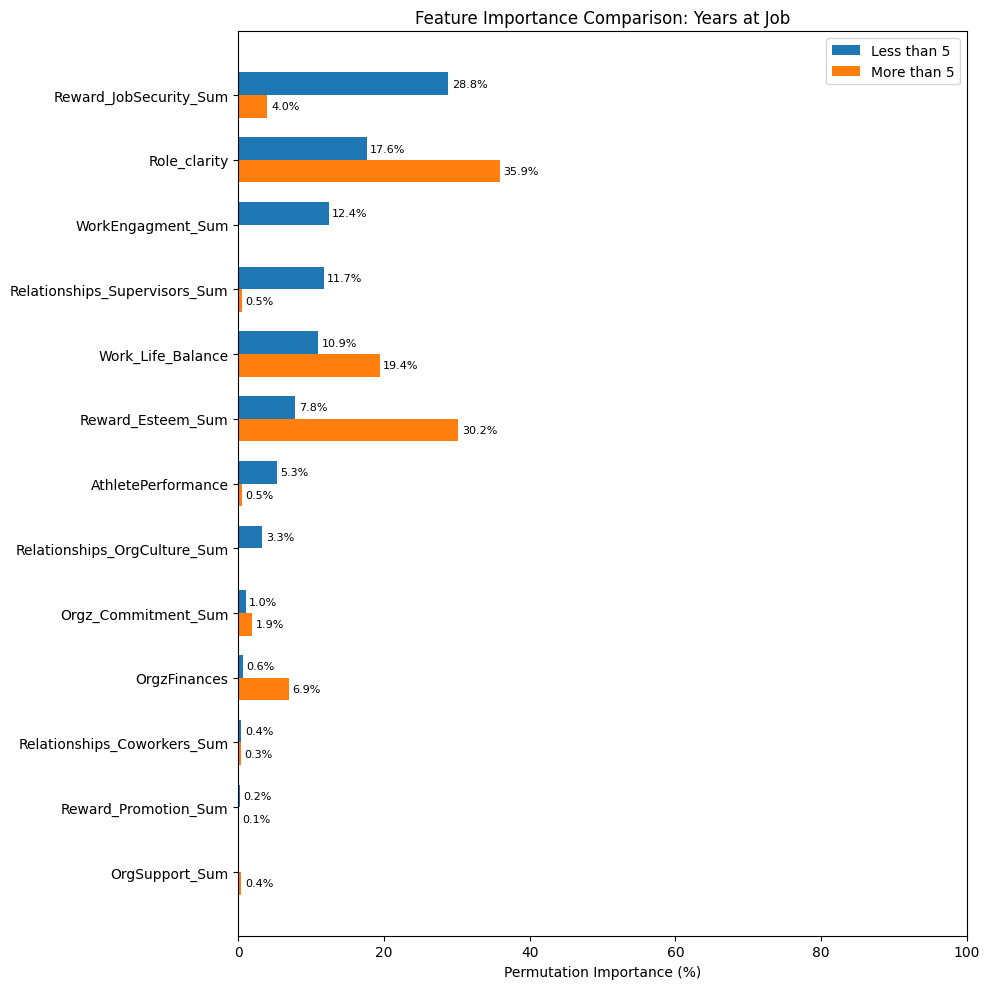

In [14]:
import matplotlib.pyplot as plt
import numpy as np

top_n = 15
less_df = group_results['Less than 5'].set_index('feature')
more_df = group_results['More than 5'].set_index('feature')

combined_features = list(
    set(less_df.head(top_n).index).union(set(more_df.head(top_n).index))
)

combined_features = sorted(combined_features, key=lambda x: (
    less_df.loc[x]['importance_pct'] if x in less_df.index else 0 +
    more_df.loc[x]['importance_pct'] if x in more_df.index else 0
), reverse=True)

less_vals = [less_df.loc[f]['importance_pct'] if f in less_df.index else 0 for f in combined_features]
more_vals = [more_df.loc[f]['importance_pct'] if f in more_df.index else 0 for f in combined_features]

y_pos = np.arange(len(combined_features))
height = 0.35

plt.figure(figsize=(10, 10))
plt.barh(y_pos - height/2, less_vals, height, label='Less than 5')
plt.barh(y_pos + height/2, more_vals, height, label='More than 5')

for i, (l, m) in enumerate(zip(less_vals, more_vals)):
    if l > 0:
        plt.text(l + 0.5, y_pos[i] - height/2, f"{l:.1f}%", va='center', fontsize=8)
    if m > 0:
        plt.text(m + 0.5, y_pos[i] + height/2, f"{m:.1f}%", va='center', fontsize=8)

plt.yticks(y_pos, combined_features)
plt.xlim(0, 100) 
plt.xlabel("Permutation Importance (%)")
plt.title("Feature Importance Comparison: Years at Job")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Counts by ExpGroup:
 ExpGroup
Less than Five Years    23
More than Five Years    16
Name: count, dtype: int64

Feature: Role_clarity
  Less than Five Years IDs (5): [19, 22, 27, 28, 31]
  More than Five Years IDs (5): [5, 9, 12, 41, 50]

Feature: Work_Life_Balance
  Less than Five Years IDs (10): [2, 3, 16, 19, 24, 27, 31, 36, 46, 49]
  More than Five Years IDs (9): [5, 9, 12, 20, 32, 35, 41, 45, 50]

Feature: Reward_JobSecurity_Sum
  Less than Five Years IDs (6): [14, 28, 31, 36, 38, 49]
  More than Five Years IDs (10): [5, 6, 17, 20, 21, 32, 37, 44, 45, 50]

Feature: Reward_Esteem_Sum
  Less than Five Years IDs (5): [28, 29, 31, 38, 46]
  More than Five Years IDs (3): [5, 21, 50]

Feature: Relationships_Supervisors_Sum
  Less than Five Years IDs (6): [3, 16, 28, 29, 38, 46]
  More than Five Years IDs (5): [5, 17, 20, 23, 41]

Feature: WorkEngagment_Sum
  Less than Five Years IDs (8): [16, 19, 25, 27, 28, 36, 46, 49]
  More than Five Years IDs (9): [5, 9, 12, 23, 35, 37, 41, 45, 50]


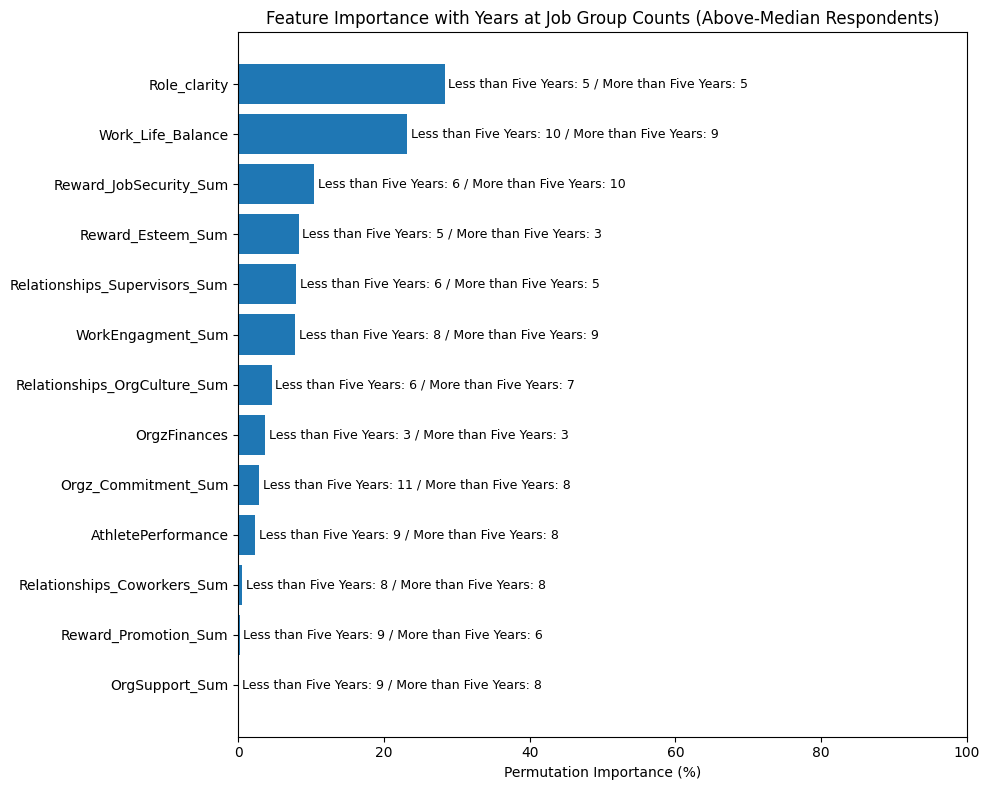

In [15]:
X_with_exp_group = X.copy()
X_with_exp_group['YrsAtJob'] = X_raw_source.loc[X_with_exp_group.index, 'YrsAtJob']

def map_exp_group(exp_str):
    if not isinstance(exp_str, str):
        return 'Unknown'
    s = exp_str.replace('–', '-') 
    if s in ['Less than 1 year', '1-2 years', '2-5 years']:
        return 'Less than Five Years'
    if s in ['5-10 years', '10-20 years', '20-30 years']:
        return 'More than Five Years'
    return 'Unknown'

X_with_exp_group['ExpGroup'] = X_with_exp_group['YrsAtJob'].apply(map_exp_group)

exp_counts = X_with_exp_group['ExpGroup'].value_counts()
print("\nCounts by ExpGroup:\n", exp_counts)

X_with_ids_exp = X.copy()
X_with_ids_exp['Participant'] = X_raw_source.loc[X.index, 'Participant #']
X_with_ids_exp['ExpGroup']   = X_with_exp_group['ExpGroup']

exp_groups = ['Less than Five Years', 'More than Five Years']

top_n = 15
top_features = importances_df.head(top_n).copy()

expgroup_labels = []
ids_less_col = []
ids_more_col = []

for feature in top_features['feature']:
    if feature in X.columns:

        median_val = X[feature].median()
        above_median = X[feature] > median_val

        counts = X_with_exp_group.loc[above_median, 'ExpGroup'].value_counts()
        parts = [f"{grp}: {counts.get(grp, 0)}" for grp in exp_groups if counts.get(grp, 0) > 0]
        label = " / ".join(parts) if parts else "N/A"

        ids_less = X_with_ids_exp.loc[above_median & (X_with_ids_exp['ExpGroup'] == 'Less than Five Years'), 'Participant'].tolist()
        ids_more = X_with_ids_exp.loc[above_median & (X_with_ids_exp['ExpGroup'] == 'More than Five Years'), 'Participant'].tolist()

        print(f"\nFeature: {feature}")
        print(f"  Less than Five Years IDs ({len(ids_less)}): {ids_less}")
        print(f"  More than Five Years IDs ({len(ids_more)}): {ids_more}")
    else:
        label = "N/A"
        ids_less, ids_more = [], []

    expgroup_labels.append(label)
    ids_less_col.append(ids_less)
    ids_more_col.append(ids_more)

top_features['expgroup_label'] = expgroup_labels
top_features['ids_less_than_five'] = ids_less_col
top_features['ids_more_than_five'] = ids_more_col

plt.figure(figsize=(10, 8))
bars = plt.barh(
    top_features['feature'][::-1],
    top_features['importance_pct'][::-1], 
    color='tab:blue'
)

for bar, label in zip(bars, top_features['expgroup_label'][::-1]):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        label,
        va='center',
        fontsize=9,
        color='black'
    )

plt.xlim(0, 100)
plt.xlabel("Permutation Importance (%)")
plt.title("Feature Importance with Years at Job Group Counts (Above-Median Respondents)")
plt.tight_layout()
plt.show()

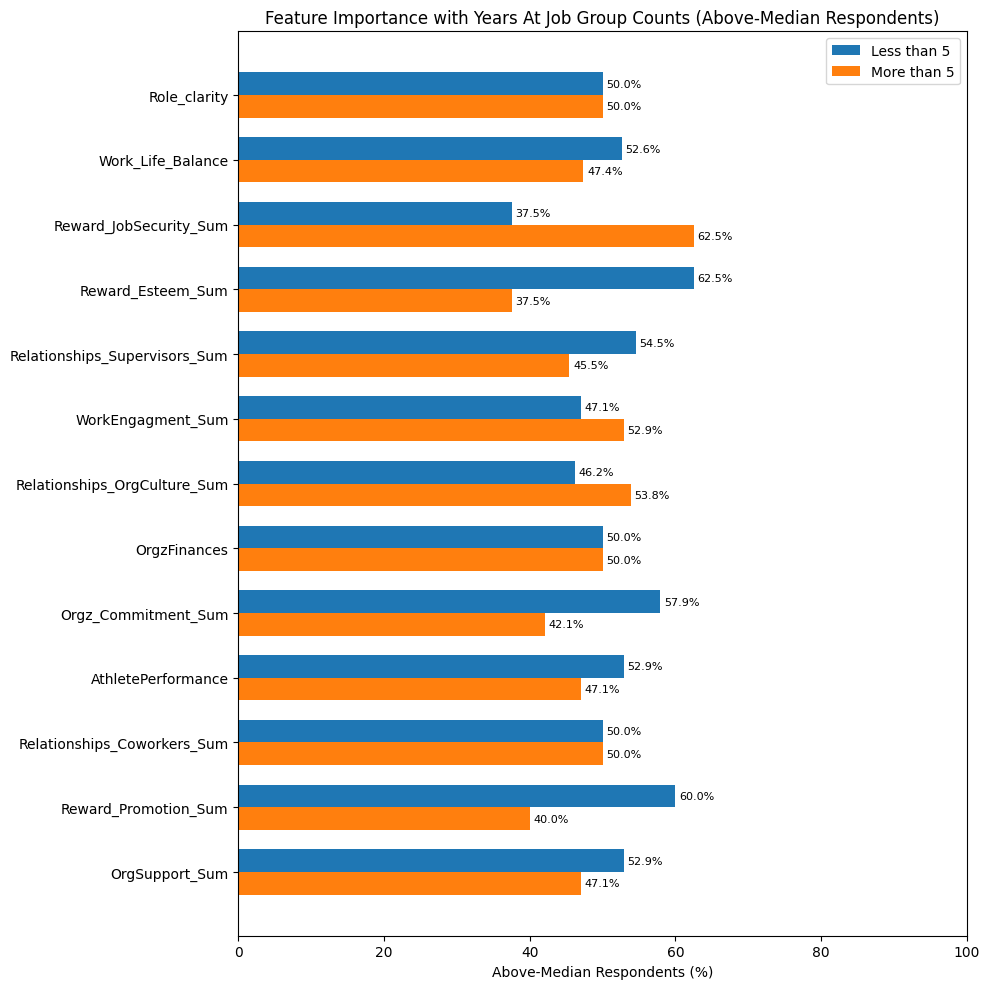

In [16]:
import matplotlib.pyplot as plt
import numpy as np

top_n = 15
top_features = importances_df.head(top_n).copy()
features = top_features['feature'].tolist()

X_with_exp_group = X.copy()
X_with_exp_group['YrsAtJob'] = X_raw_source.loc[X_with_exp_group.index, 'YrsAtJob']

def map_exp_group(exp_str):
    if exp_str in ['Less than 1 year', '1–2 years', '2–5 years']:
        return 'Less than 5'
    elif exp_str in ['5–10 years', '10–20 years', '20-30 years']:
        return 'More than 5'
    else:
        return 'Unknown'

X_with_exp_group['ExpGroup'] = X_with_exp_group['YrsAtJob'].apply(map_exp_group)

less_counts = []
more_counts = []

for feat in features:
    if feat in X.columns:
        median_val = X[feat].median()
        above_median = X[feat] > median_val
        group_counts = X_with_exp_group.loc[above_median, 'ExpGroup'].value_counts(normalize=True) * 100
        less_counts.append(group_counts.get('Less than 5', 0))
        more_counts.append(group_counts.get('More than 5', 0))
    else:
        less_counts.append(0)
        more_counts.append(0)

y_pos = np.arange(len(features))
height = 0.35

plt.figure(figsize=(10, 10))
plt.barh(y_pos - height/2, less_counts, height, label='Less than 5')
plt.barh(y_pos + height/2, more_counts, height, label='More than 5')

for i, (l, m) in enumerate(zip(less_counts, more_counts)):
    if l > 0:
        plt.text(l + 0.5, y_pos[i] - height/2, f"{l:.1f}%", va='center', fontsize=8)
    if m > 0:
        plt.text(m + 0.5, y_pos[i] + height/2, f"{m:.1f}%", va='center', fontsize=8)


plt.yticks(y_pos, features)
plt.xlim(0, 100)
plt.xlabel("Above-Median Respondents (%)")
plt.title("Feature Importance with Years At Job Group Counts (Above-Median Respondents)")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

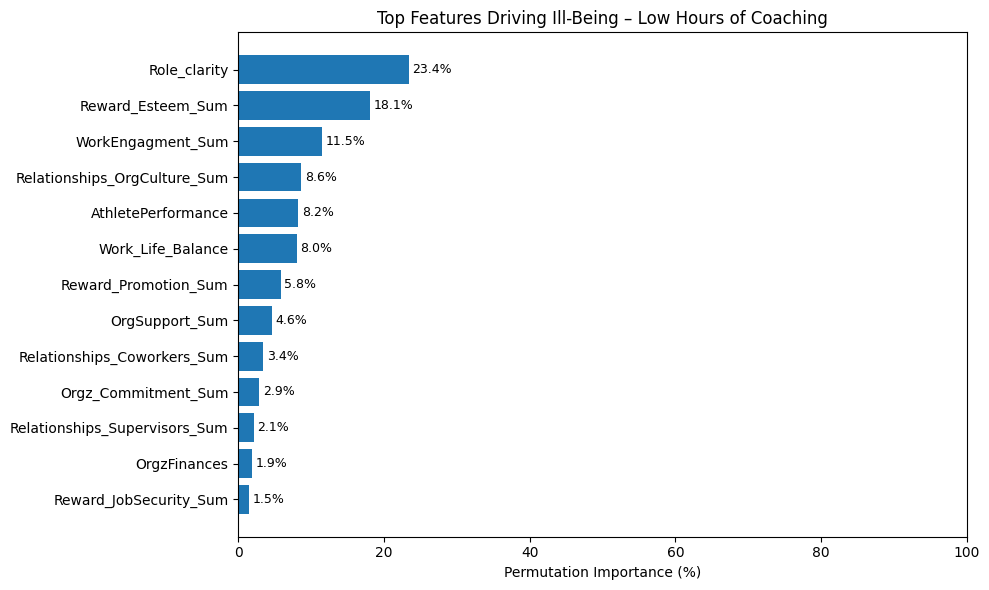

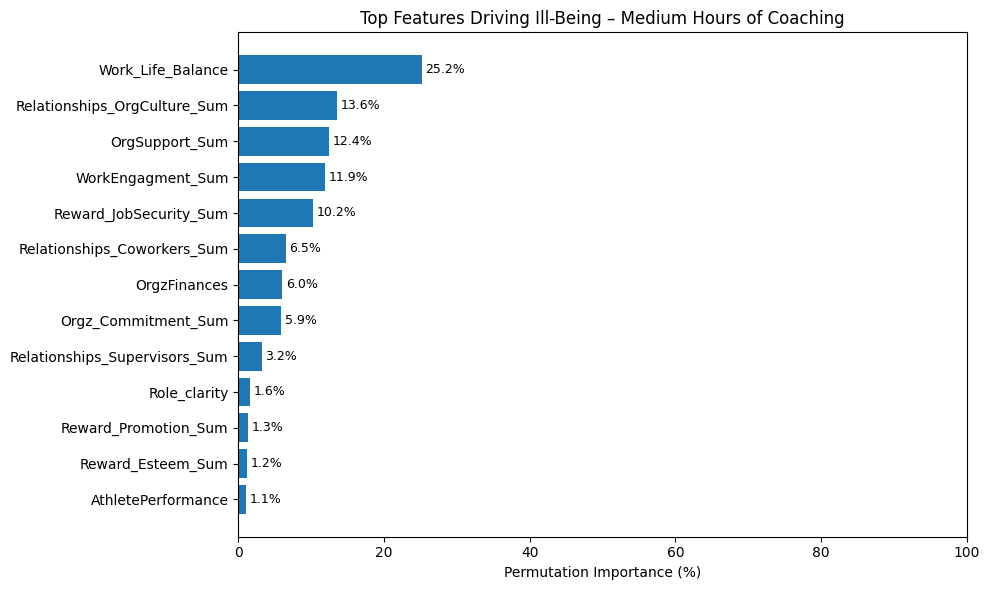

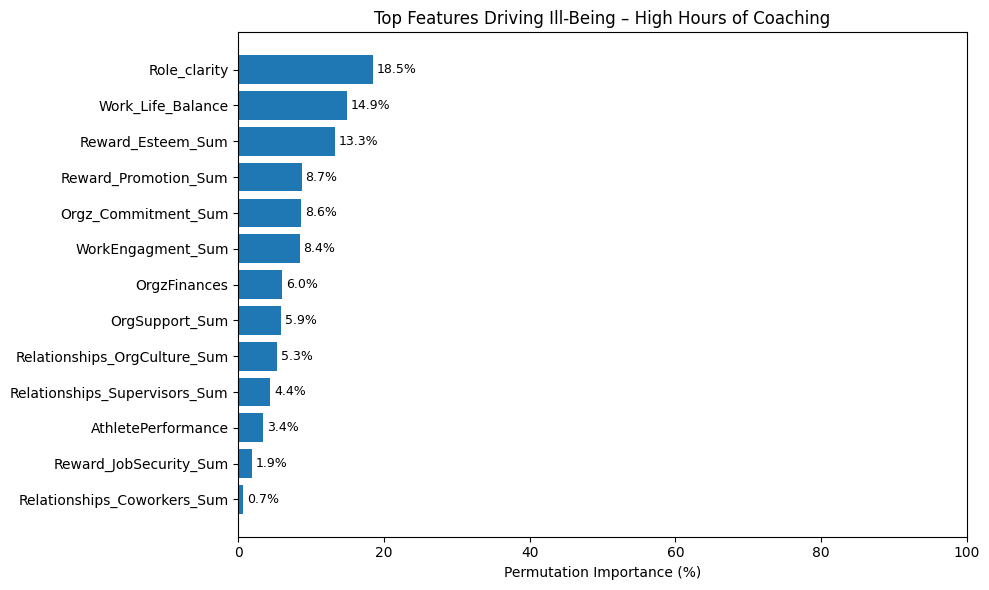

In [17]:

X_with_hcoaching = X.copy()
X_with_hcoaching['HrsCoaching'] = X_raw_source.loc[X_with_hcoaching.index, 'HrsCoaching']

def map_coaching_group(val):
    if val in ['7 – 12 hours/week', '13 – 18 hours/week']:
        return 'Low'
    elif val in ['19 – 24 hours/week', '25 – 30 hours/week']:
        return 'Medium'
    elif val in ['31 – 36 hours/week', '37 or more hours/week']:
        return 'High'
    else:
        return 'Unknown'
    
X_with_hcoaching['HCoachingGroup'] = X_with_hcoaching['HrsCoaching'].apply(map_coaching_group)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

coaching_group_results = {}

for group in ['Low', 'Medium', 'High']:
    idx = X_with_hcoaching['HCoachingGroup'] == group
    X_group = X.loc[idx]
    y_group = y.loc[idx]

    if len(X_group) < 5:
        print(f"⚠️ Skipping {group} group due to too few samples ({len(X_group)})")
        continue

    group_pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('regressor', RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5))
    ])
    group_pipeline.fit(X_group, y_group)

    X_transformed_group = group_pipeline.named_steps['preprocess'].transform(X_group)

    group_feature_names = []
    group_feature_names.extend(numeric_cols)
    cat_transformer = group_pipeline.named_steps['preprocess'].named_transformers_.get('cat')
    if categorical_cols and cat_transformer and hasattr(cat_transformer, 'get_feature_names_out'):
        group_feature_names.extend(list(cat_transformer.get_feature_names_out(categorical_cols)))

    if len(group_feature_names) != X_transformed_group.shape[1]:
        group_feature_names = [f"feature_{i}" for i in range(X_transformed_group.shape[1])]

    perm_result = permutation_importance(
        group_pipeline.named_steps['regressor'],
        X_transformed_group,
        y_group,
        n_repeats=20,
        random_state=42
    )

    group_importance_df = pd.DataFrame({
        'feature': group_feature_names,
        'importance_mean': perm_result.importances_mean,
        'importance_std': perm_result.importances_std
    }).sort_values(by='importance_mean', ascending=False)

    total = group_importance_df['importance_mean'].sum()
    group_importance_df['importance_pct'] = (group_importance_df['importance_mean'] / total) * 100
    group_importance_df['importance_pct'] = group_importance_df['importance_pct'].round(1)

    coaching_group_results[group] = group_importance_df

for group, df in coaching_group_results.items():
    top_features = df.head(15).copy()
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(
        top_features['feature'][::-1],
        top_features['importance_pct'][::-1],
        color='tab:blue'
    )

    for bar, pct in zip(bars, top_features['importance_pct'][::-1]):
        if pct > 0:
            plt.text(
                bar.get_width() + 0.5,
                bar.get_y() + bar.get_height() / 2,
                f"{pct:.1f}%",
                va='center',
                fontsize=9
            )

    plt.xlabel("Permutation Importance (%)")
    plt.xlim(0, 100)
    plt.title(f"Top Features Driving Ill-Being – {group} Hours of Coaching")
    plt.tight_layout()
    plt.show()

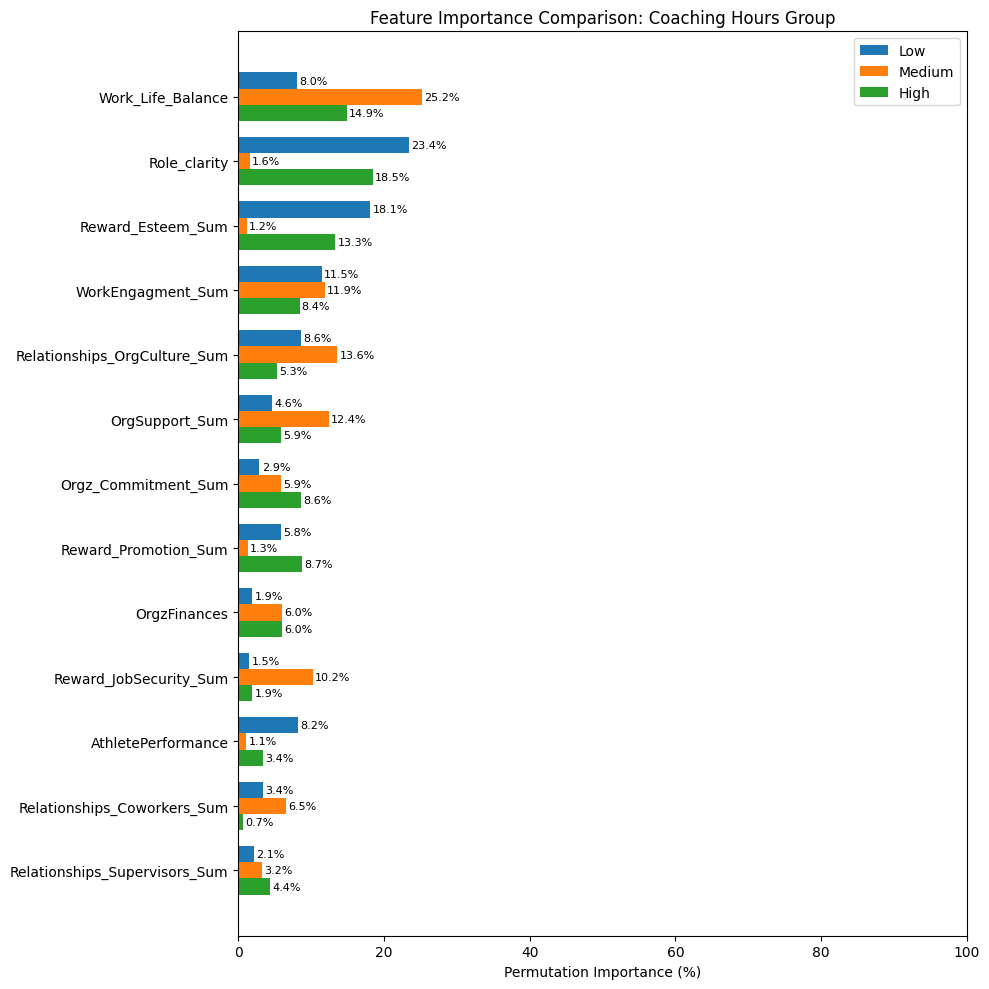

In [18]:
import matplotlib.pyplot as plt
import numpy as np

top_n = 15
low_df = coaching_group_results['Low'].set_index('feature')
med_df = coaching_group_results['Medium'].set_index('feature')
high_df = coaching_group_results['High'].set_index('feature')

combined_features = list(
    set(low_df.head(top_n).index)
    .union(med_df.head(top_n).index)
    .union(high_df.head(top_n).index)
)

combined_features = sorted(combined_features, key=lambda x: (
    (low_df.loc[x]['importance_pct'] if x in low_df.index else 0) +
    (med_df.loc[x]['importance_pct'] if x in med_df.index else 0) +
    (high_df.loc[x]['importance_pct'] if x in high_df.index else 0)
), reverse=True)

low_vals = [low_df.loc[f]['importance_pct'] if f in low_df.index else 0 for f in combined_features]
med_vals = [med_df.loc[f]['importance_pct'] if f in med_df.index else 0 for f in combined_features]
high_vals = [high_df.loc[f]['importance_pct'] if f in high_df.index else 0 for f in combined_features]

y_pos = np.arange(len(combined_features))
width = 0.25

plt.figure(figsize=(10, 10))
plt.barh(y_pos - width, low_vals, width, label='Low')
plt.barh(y_pos, med_vals, width, label='Medium')
plt.barh(y_pos + width, high_vals, width, label='High')

for i, (l, m, h) in enumerate(zip(low_vals, med_vals, high_vals)):
    if l > 0:
        plt.text(l + 0.3, y_pos[i] - width, f"{l:.1f}%", va='center', fontsize=8)
    if m > 0:
        plt.text(m + 0.3, y_pos[i], f"{m:.1f}%", va='center',  fontsize=8)
    if h > 0:
        plt.text(h + 0.3, y_pos[i] + width, f"{h:.1f}%", va='center', fontsize=8)

plt.yticks(y_pos, combined_features)
plt.xlim(0, 100)
plt.xlabel("Permutation Importance (%)")
plt.title("Feature Importance Comparison: Coaching Hours Group")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Counts by CoachingHrGroup:
 CoachingHrGroup
Low       15
Medium    14
High      10
Name: count, dtype: int64

Feature: Role_clarity
  Low above-median IDs (4): [5, 9, 19, 50]
  Medium above-median IDs (4): [22, 27, 31, 41]
  High above-median IDs (2): [12, 28]

Feature: Work_Life_Balance
  Low above-median IDs (10): [2, 3, 5, 9, 19, 20, 24, 32, 36, 50]
  Medium above-median IDs (5): [16, 27, 31, 41, 46]
  High above-median IDs (4): [12, 35, 45, 49]

Feature: Reward_JobSecurity_Sum
  Low above-median IDs (8): [5, 14, 20, 21, 32, 36, 44, 50]
  Medium above-median IDs (4): [17, 31, 37, 38]
  High above-median IDs (4): [6, 28, 45, 49]

Feature: Reward_Esteem_Sum
  Low above-median IDs (3): [5, 21, 50]
  Medium above-median IDs (4): [29, 31, 38, 46]
  High above-median IDs (1): [28]

Feature: Relationships_Supervisors_Sum
  Low above-median IDs (3): [3, 5, 20]
  Medium above-median IDs (7): [16, 17, 23, 29, 38, 41, 46]
  High above-median IDs (1): [28]

Feature: WorkEngagment_Sum
  Low abo

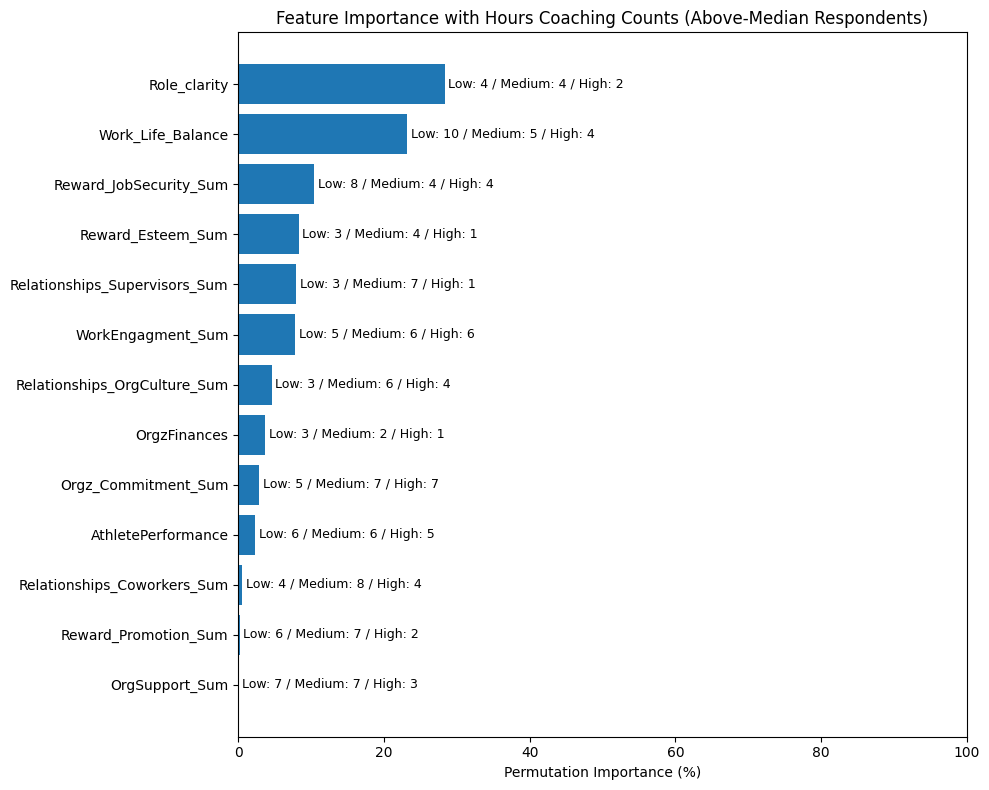

In [19]:
X_with_hrsCoaching_group = X.copy()
X_with_hrsCoaching_group['HrsCoaching'] = X_raw_source.loc[X_with_hrsCoaching_group.index, 'HrsCoaching']

def _map_coaching_group_safe(v):
    try:
        return map_coaching_group(v)
    except Exception:
        return 'Unknown'

X_with_hrsCoaching_group['CoachingHrGroup'] = X_with_hrsCoaching_group['HrsCoaching'].apply(_map_coaching_group_safe)

hCoaching_counts = X_with_hrsCoaching_group['CoachingHrGroup'].value_counts()
print("\nCounts by CoachingHrGroup:\n", hCoaching_counts)

X_with_ids_coach = X.copy()
X_with_ids_coach['Participant']   = X_raw_source.loc[X.index, 'Participant #']
X_with_ids_coach['CoachingHrGroup'] = X_with_hrsCoaching_group['CoachingHrGroup']

coaching_groups = list(hCoaching_counts.index) 

top_n = 15
top_features = importances_df.head(top_n).copy()

hCoachinggroup_labels = []
ids_by_group_cols = {g: [] for g in coaching_groups}

for feature in top_features['feature']:
    if feature in X.columns:
        med = X[feature].median()
        above_median = X[feature] > med

        counts = X_with_hrsCoaching_group.loc[above_median, 'CoachingHrGroup'].value_counts()
        parts = [f"{g}: {counts.get(g, 0)}" for g in coaching_groups if counts.get(g, 0) > 0]
        label = " / ".join(parts) if parts else "N/A"

        ids_this_feat = {}
        for g in coaching_groups:
            ids_list = X_with_ids_coach.loc[above_median & (X_with_ids_coach['CoachingHrGroup'] == g),
                                            'Participant'].tolist()
            ids_this_feat[g] = ids_list
            ids_by_group_cols[g].append(ids_list)

        print(f"\nFeature: {feature}")
        for g in coaching_groups:
            print(f"  {g} above-median IDs ({len(ids_this_feat[g])}): {ids_this_feat[g]}")
    else:
        label = "N/A"
        for g in coaching_groups:
            ids_by_group_cols[g].append([])

    hCoachinggroup_labels.append(label)

top_features['hCoachinggroup_labels'] = hCoachinggroup_labels
for g in coaching_groups:
    safe_col = f'ids_{str(g).lower().replace(" ", "_")}'
    top_features[safe_col] = ids_by_group_cols[g]

plt.figure(figsize=(10, 8))
bars = plt.barh(
    top_features['feature'][::-1],
    top_features['importance_pct'][::-1],
    color='tab:blue'
)

for bar, label in zip(bars, top_features['hCoachinggroup_labels'][::-1]):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        label,
        va='center',
        fontsize=9,
        color='black'
    )

plt.xlim(0, 100)
plt.xlabel("Permutation Importance (%)")
plt.title("Feature Importance with Hours Coaching Counts (Above-Median Respondents)")
plt.tight_layout()
plt.show()

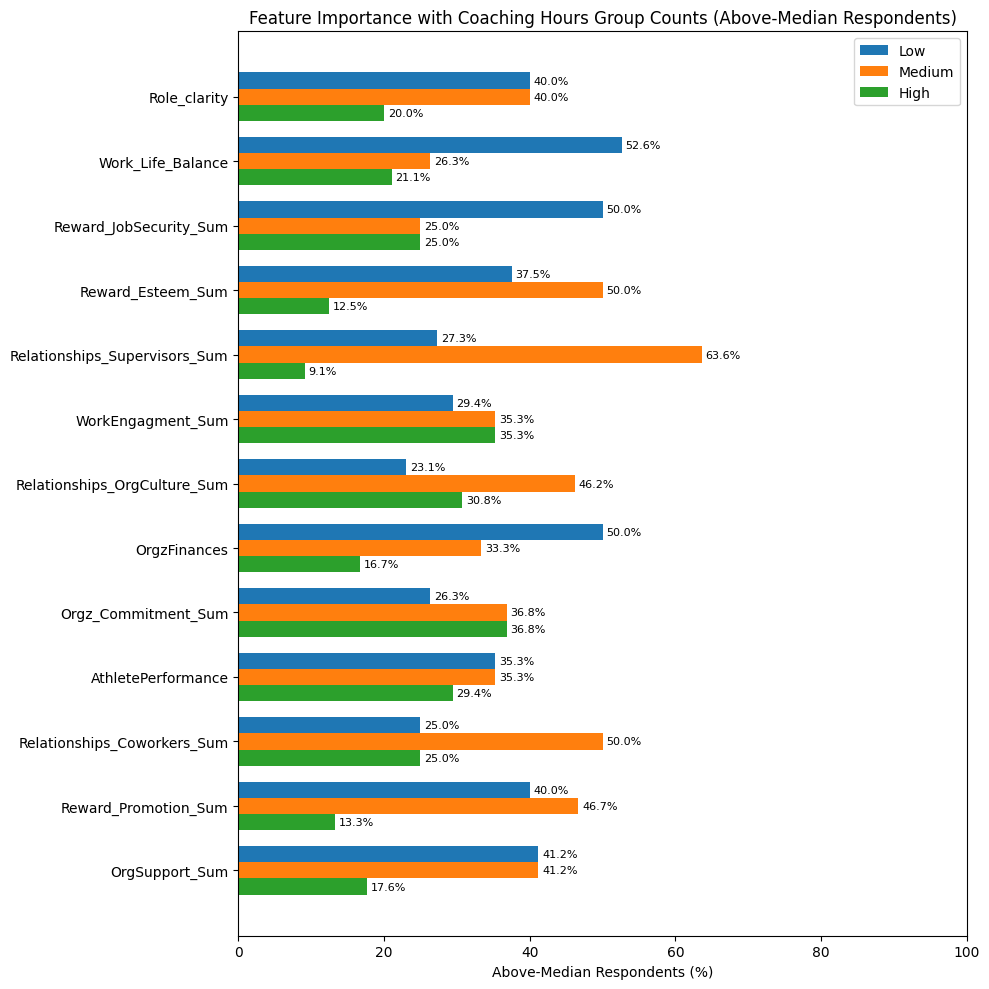

In [20]:
import matplotlib.pyplot as plt
import numpy as np

top_n = 15
top_features = importances_df.head(top_n).copy()
features = top_features['feature'].tolist()

X_with_coach_group = X.copy()
X_with_coach_group['HrsCoaching'] = X_raw_source.loc[X_with_coach_group.index, 'HrsCoaching']

def map_coaching_group(val):
    if val in ['7 – 12 hours/week', '13 – 18 hours/week']:
        return 'Low'
    elif val in ['19 – 24 hours/week', '25 – 30 hours/week']:
        return 'Medium'
    elif val in ['31 – 36 hours/week', '37 or more hours/week']:
        return 'High'
    else:
        return 'Unknown'

X_with_coach_group['CoachingGroup'] = X_with_coach_group['HrsCoaching'].apply(map_coaching_group)

low_counts = []
med_counts = []
high_counts = []

for feat in features:
    if feat in X.columns:
        median_val = X[feat].median()
        above_median = X[feat] > median_val
        group_counts = X_with_coach_group.loc[above_median, 'CoachingGroup'].value_counts(normalize=True) * 100
        low_counts.append(group_counts.get('Low', 0))
        med_counts.append(group_counts.get('Medium', 0))
        high_counts.append(group_counts.get('High', 0))
    else:
        low_counts.append(0)
        med_counts.append(0)
        high_counts.append(0)

y_pos = np.arange(len(features))
height = 0.25

plt.figure(figsize=(10, 10))
plt.barh(y_pos - height, low_counts, height, label='Low')
plt.barh(y_pos, med_counts, height, label='Medium')
plt.barh(y_pos + height, high_counts, height, label='High')

for i, (l, m, h) in enumerate(zip(low_counts, med_counts, high_counts)):
    if l > 0:
        plt.text(l + 0.5, y_pos[i] - height, f"{l:.1f}%", va='center', fontsize=8)
    if m > 0:
        plt.text(m + 0.5, y_pos[i], f"{m:.1f}%", va='center', fontsize=8)
    if h > 0:
        plt.text(h + 0.5, y_pos[i] + height, f"{h:.1f}%", va='center', fontsize=8)

plt.yticks(y_pos, features)
plt.xlabel("Above-Median Respondents (%)")
plt.xlim(0, 100)
plt.title("Feature Importance with Coaching Hours Group Counts (Above-Median Respondents)")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

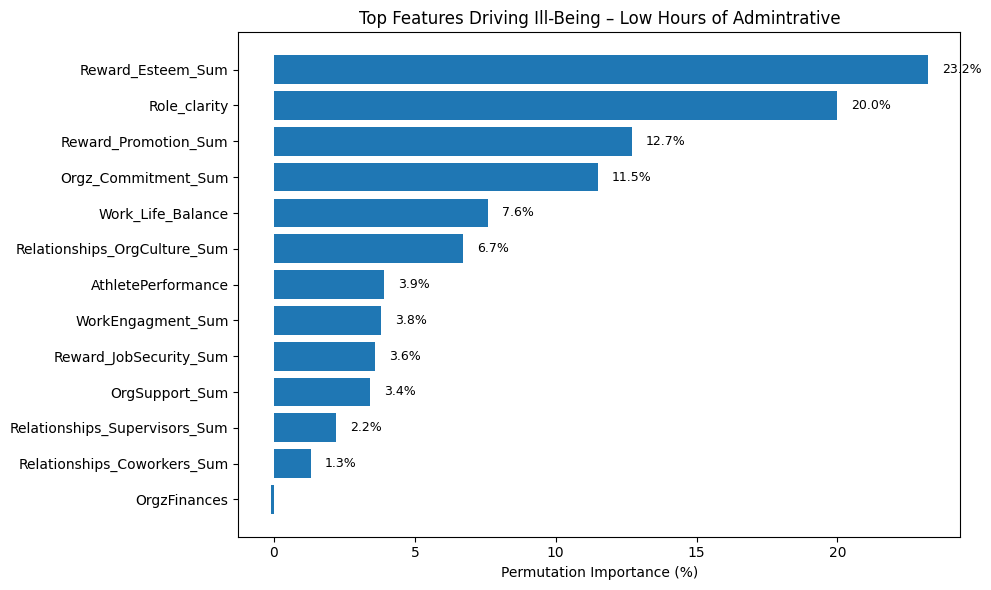

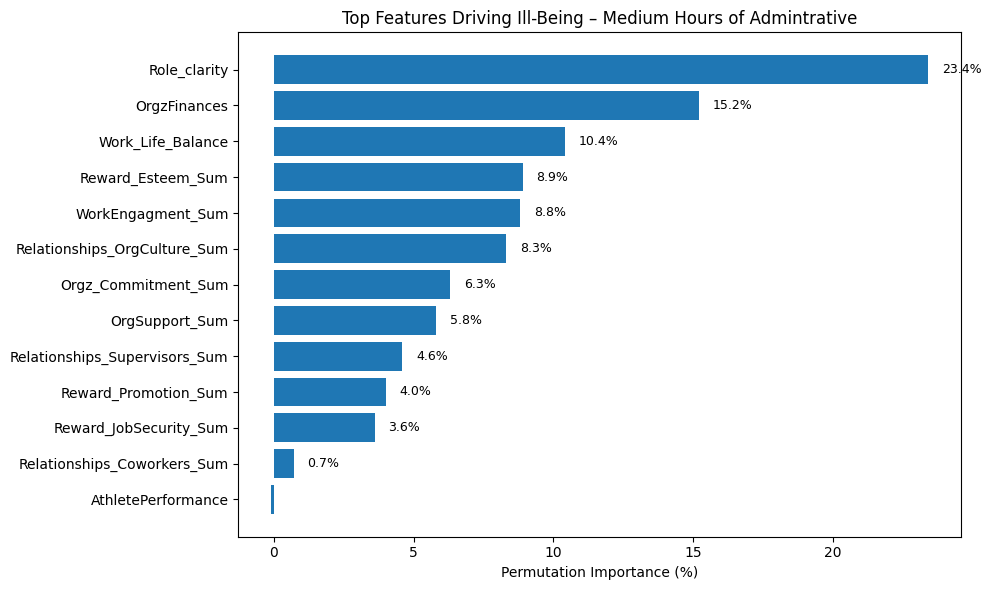

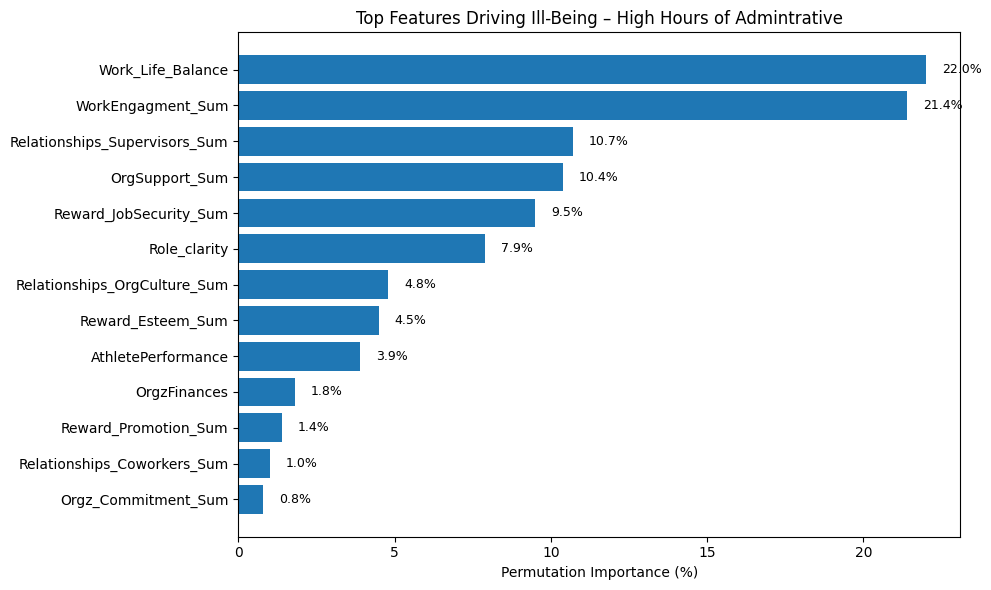

In [21]:
X_with_hAdmintrative = X.copy()
X_with_hAdmintrative['HrsAdmintrative'] = X_raw_source.loc[X_with_hAdmintrative.index, 'HrsAdmintrative']

def map_admin_group(val):
    if val in ['1 – 4 hours/week', '5 – 8 hours/week', '9 – 12 hours/week']:
        return 'Low'
    elif val in ['13 – 16 hours/week', '17 – 20 hours/week']:
        return 'Medium'
    elif val in ['21 or more hours/week']:
        return 'High'
    else:
        return 'Unknown'
    
X_with_hAdmintrative['HAdmintrativeGroup'] = X_with_hAdmintrative['HrsAdmintrative'].apply(map_admin_group)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

admin_group_results = {}

for group in ['Low', 'Medium', 'High']:
    idx = X_with_hAdmintrative['HAdmintrativeGroup'] == group
    X_group = X_with_hAdmintrative.loc[idx]
    y_group = y.loc[idx]

    if len(X_group) < 5:
        print(f"⚠️ Skipping {group} group due to too few samples ({len(X_group)})")
        continue

    group_pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('regressor', RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5))
    ])
    group_pipeline.fit(X_group, y_group)

    X_transformed_group = group_pipeline.named_steps['preprocess'].transform(X_group)

    group_feature_names = []
    group_feature_names.extend(numeric_cols)
    cat_transformer = group_pipeline.named_steps['preprocess'].named_transformers_.get('cat')
    if categorical_cols and cat_transformer and hasattr(cat_transformer, 'get_feature_names_out'):
        group_feature_names.extend(list(cat_transformer.get_feature_names_out(categorical_cols)))

    if len(group_feature_names) != X_transformed_group.shape[1]:
        group_feature_names = [f"feature_{i}" for i in range(X_transformed_group.shape[1])]

    perm_result = permutation_importance(
        group_pipeline.named_steps['regressor'],
        X_transformed_group,
        y_group,
        n_repeats=20,
        random_state=42
    )

    group_importance_df = pd.DataFrame({
        'feature': group_feature_names,
        'importance_mean': perm_result.importances_mean,
        'importance_std': perm_result.importances_std
    }).sort_values(by='importance_mean', ascending=False)

    total = group_importance_df['importance_mean'].sum()
    group_importance_df['importance_pct'] = (group_importance_df['importance_mean'] / total) * 100
    group_importance_df['importance_pct'] = group_importance_df['importance_pct'].round(1)

    admin_group_results[group] = group_importance_df

for group, df in admin_group_results.items():
    top_features = df.head(15).copy()
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(
        top_features['feature'][::-1],
        top_features['importance_pct'][::-1],
        color='tab:blue'
    )

    for bar, pct in zip(bars, top_features['importance_pct'][::-1]):
        if pct > 0:
            plt.text(
                bar.get_width() + 0.5,
                bar.get_y() + bar.get_height() / 2,
                f"{pct:.1f}%",
                va='center',
                fontsize=9
            )

    plt.xlabel("Permutation Importance (%)")
    plt.title(f"Top Features Driving Ill-Being – {group} Hours of Admintrative")
    plt.tight_layout()
    plt.show()

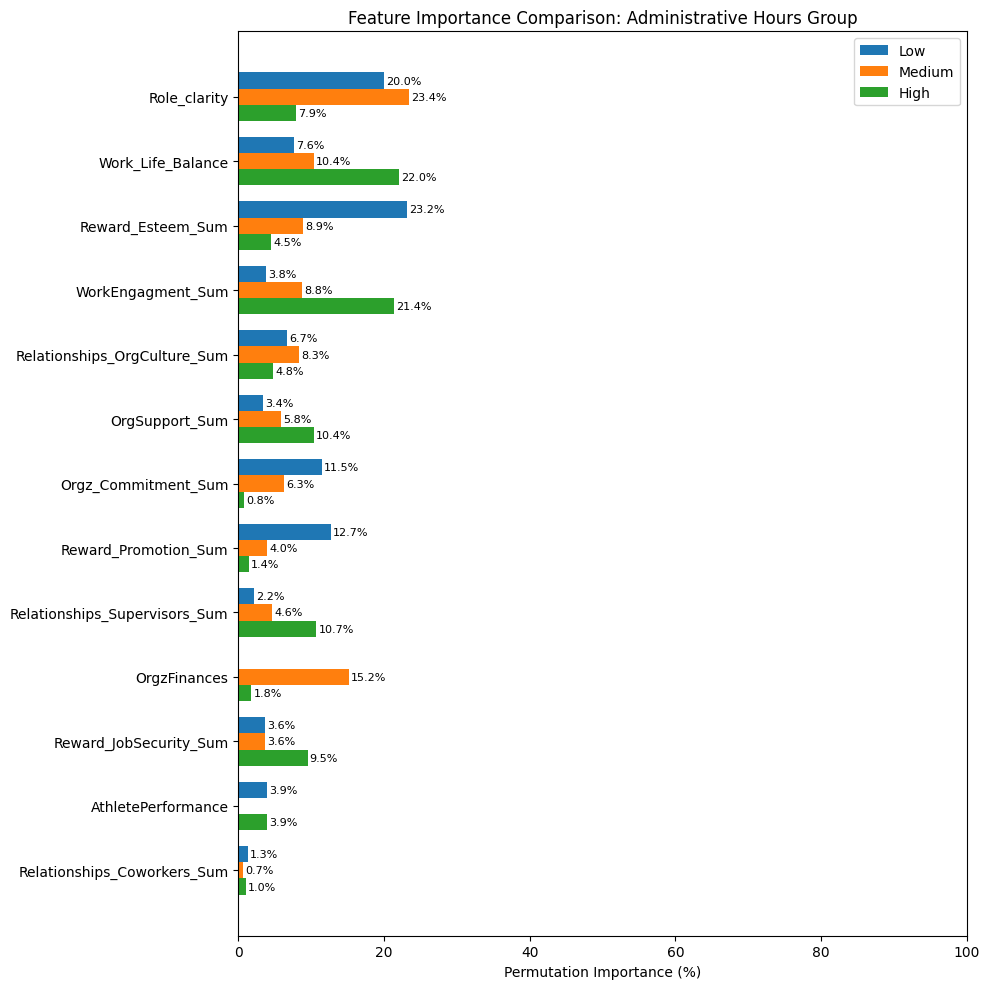

In [22]:
import matplotlib.pyplot as plt
import numpy as np

top_n = 15
low_df = admin_group_results['Low'].set_index('feature')
med_df = admin_group_results['Medium'].set_index('feature')
high_df = admin_group_results['High'].set_index('feature')

combined_features = list(
    set(low_df.head(top_n).index)
    .union(med_df.head(top_n).index)
    .union(high_df.head(top_n).index)
)

combined_features = sorted(combined_features, key=lambda x: (
    (low_df.loc[x]['importance_pct'] if x in low_df.index else 0) +
    (med_df.loc[x]['importance_pct'] if x in med_df.index else 0) +
    (high_df.loc[x]['importance_pct'] if x in high_df.index else 0)
), reverse=True)

low_vals = [low_df.loc[f]['importance_pct'] if f in low_df.index else 0 for f in combined_features]
med_vals = [med_df.loc[f]['importance_pct'] if f in med_df.index else 0 for f in combined_features]
high_vals = [high_df.loc[f]['importance_pct'] if f in high_df.index else 0 for f in combined_features]

y_pos = np.arange(len(combined_features))
height = 0.25

plt.figure(figsize=(10, 10))
plt.barh(y_pos - height, low_vals, height, label='Low')
plt.barh(y_pos, med_vals, height, label='Medium')
plt.barh(y_pos + height, high_vals, height, label='High')

for i, (l, m, h) in enumerate(zip(low_vals, med_vals, high_vals)):
    if l > 0:
        plt.text(l + 0.3, y_pos[i] - height, f"{l:.1f}%", va='center', fontsize=8)
    if m > 0:
        plt.text(m + 0.3, y_pos[i], f"{m:.1f}%", va='center', fontsize=8)
    if h > 0:
        plt.text(h + 0.3, y_pos[i] + height, f"{h:.1f}%", va='center', fontsize=8)

plt.yticks(y_pos, combined_features)
plt.xlim(0, 100)
plt.xlabel("Permutation Importance (%)")
plt.title("Feature Importance Comparison: Administrative Hours Group")
plt.legend()
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


Counts by AdminHrGroup:
 AdminHrGroup
Medium    14
High      13
Low       12
Name: count, dtype: int64

Feature: Role_clarity
  Low above-median IDs (1): [28]
  Medium above-median IDs (5): [9, 12, 27, 31, 41]
  High above-median IDs (4): [5, 19, 22, 50]

Feature: Work_Life_Balance
  Low above-median IDs (5): [2, 3, 20, 35, 49]
  Medium above-median IDs (8): [9, 12, 16, 24, 27, 31, 41, 45]
  High above-median IDs (6): [5, 19, 32, 36, 46, 50]

Feature: Reward_JobSecurity_Sum
  Low above-median IDs (6): [14, 17, 20, 28, 37, 49]
  Medium above-median IDs (4): [6, 31, 44, 45]
  High above-median IDs (6): [5, 21, 32, 36, 38, 50]

Feature: Reward_Esteem_Sum
  Low above-median IDs (1): [28]
  Medium above-median IDs (1): [31]
  High above-median IDs (6): [5, 21, 29, 38, 46, 50]

Feature: Relationships_Supervisors_Sum
  Low above-median IDs (4): [3, 17, 20, 28]
  Medium above-median IDs (3): [16, 23, 41]
  High above-median IDs (4): [5, 29, 38, 46]

Feature: WorkEngagment_Sum
  Low above-medi

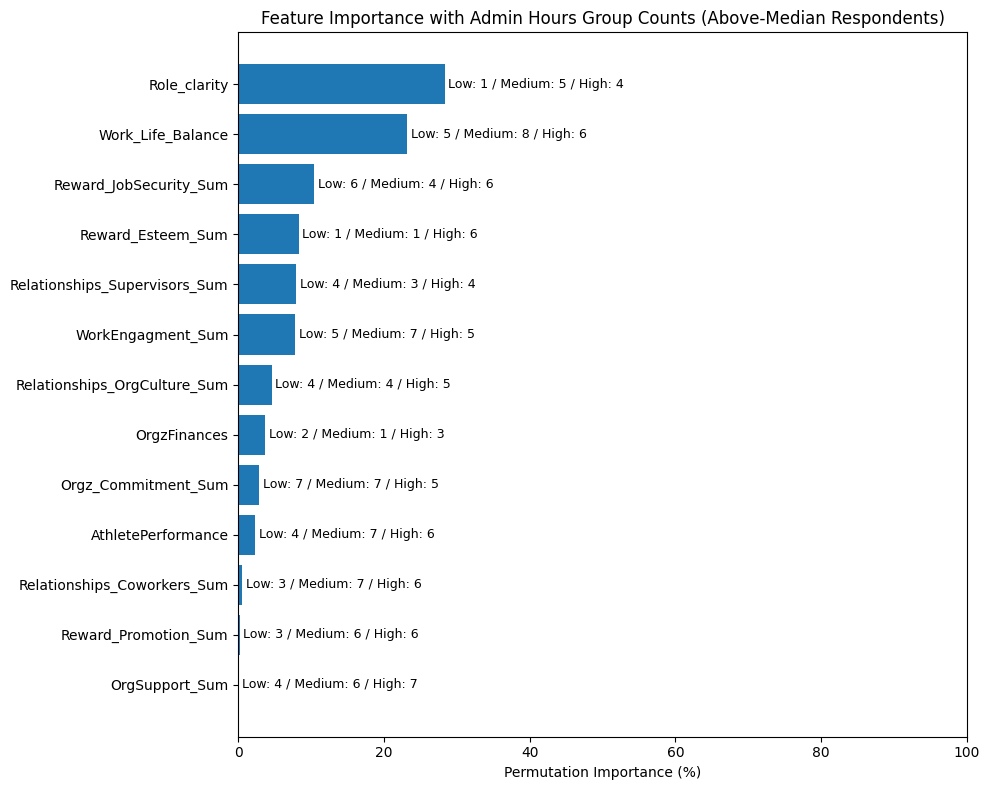

In [23]:
X_with_hrsAdmin_group = X.copy()
X_with_hrsAdmin_group['HrsAdmintrative'] = X_raw_source.loc[X_with_hrsAdmin_group.index, 'HrsAdmintrative']

def map_admin_group(val):
    if val in ['1 – 4 hours/week', '5 – 8 hours/week', '9 – 12 hours/week']:
        return 'Low'
    elif val in ['13 – 16 hours/week', '17 – 20 hours/week']:
        return 'Medium'
    elif val in ['21 or more hours/week']:
        return 'High'
    else:
        return 'Unknown'

X_with_hrsAdmin_group['AdminHrGroup'] = X_with_hrsAdmin_group['HrsAdmintrative'].apply(map_admin_group)

admin_counts = X_with_hrsAdmin_group['AdminHrGroup'].value_counts()
print("\nCounts by AdminHrGroup:\n", admin_counts)

X_with_ids_admin = X.copy()
X_with_ids_admin['Participant']  = X_raw_source.loc[X.index, 'Participant #']
X_with_ids_admin['AdminHrGroup'] = X_with_hrsAdmin_group['AdminHrGroup']

admin_groups = ['Low', 'Medium', 'High']  

top_n = 15
top_features = importances_df.head(top_n).copy()

admin_group_labels = []
ids_cols = {g: [] for g in admin_groups}

for feature in top_features['feature']:
    if feature in X.columns:
        med = X[feature].median()
        above_median = X[feature] > med

        counts = X_with_hrsAdmin_group.loc[above_median, 'AdminHrGroup'].value_counts()
        parts = [f"{g}: {counts.get(g, 0)}" for g in admin_groups if counts.get(g, 0) > 0]
        label = " / ".join(parts) if parts else "N/A"

        ids_this_feat = {}
        for g in admin_groups:
            ids_list = X_with_ids_admin.loc[
                above_median & (X_with_ids_admin['AdminHrGroup'] == g),
                'Participant'
            ].tolist()
            ids_this_feat[g] = ids_list
            ids_cols[g].append(ids_list)

        print(f"\nFeature: {feature}")
        for g in admin_groups:
            print(f"  {g} above-median IDs ({len(ids_this_feat[g])}): {ids_this_feat[g]}")
    else:
        label = "N/A"
        for g in admin_groups:
            ids_cols[g].append([])

    admin_group_labels.append(label)

top_features['admin_group_labels'] = admin_group_labels
for g in admin_groups:
    safe_col = f'ids_admin_{g.lower()}'
    top_features[safe_col] = ids_cols[g]

plt.figure(figsize=(10, 8))
bars = plt.barh(
    top_features['feature'][::-1],
    top_features['importance_pct'][::-1],
    color='tab:blue'
)

for bar, label in zip(bars, top_features['admin_group_labels'][::-1]):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        label,
        va='center',
        fontsize=9,
        color='black'
    )

plt.xlim(0, 100)
plt.xlabel("Permutation Importance (%)")
plt.title("Feature Importance with Admin Hours Group Counts (Above-Median Respondents)")
plt.tight_layout()
plt.show()

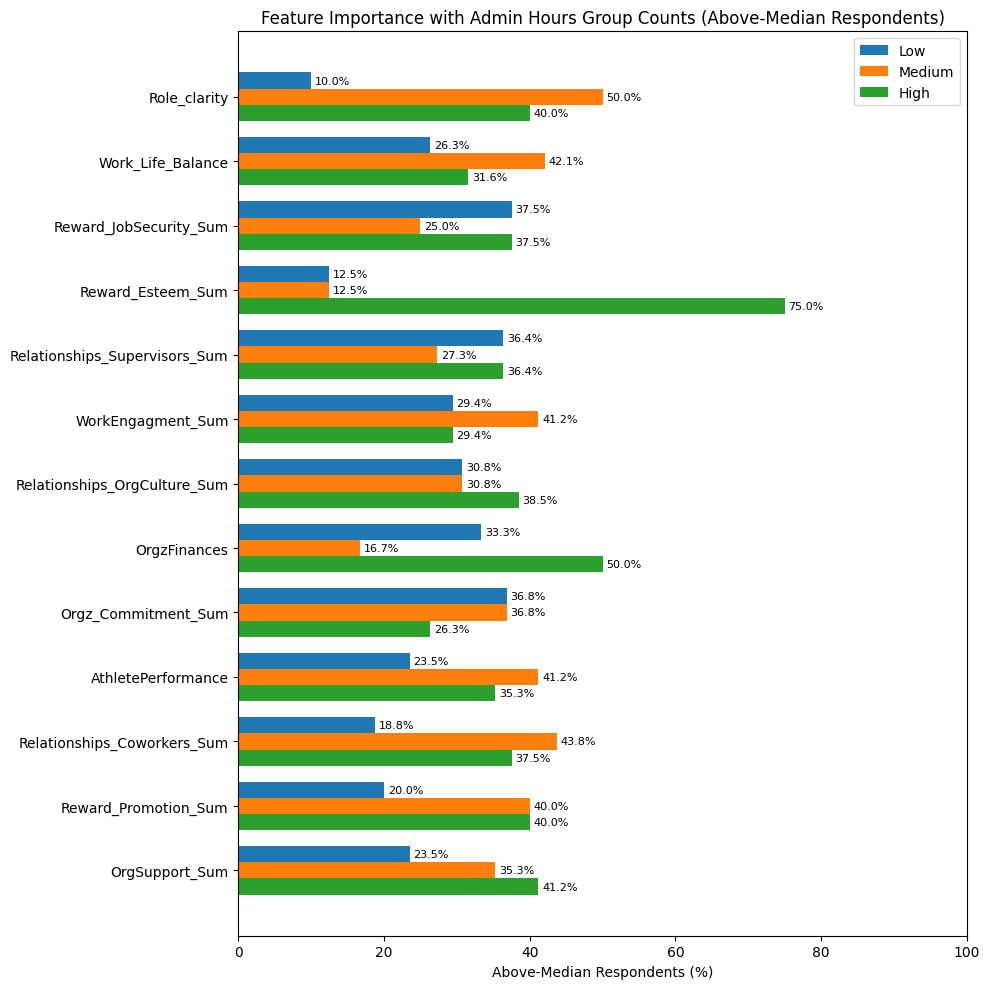

In [24]:
import matplotlib.pyplot as plt
import numpy as np

top_n = 15
top_features = importances_df.head(top_n).copy()
features = top_features['feature'].tolist()

X_with_admin_group = X.copy()
X_with_admin_group['HrsAdmintrative'] = X_raw_source.loc[X_with_admin_group.index, 'HrsAdmintrative']

def map_admin_group(val):
    if val in ['1 – 4 hours/week', '5 – 8 hours/week', '9 – 12 hours/week']:
        return 'Low'
    elif val in ['13 – 16 hours/week', '17 – 20 hours/week']:
        return 'Medium'
    elif val in ['21 or more hours/week']:
        return 'High'
    else:
        return 'Unknown'

X_with_admin_group['AdminGroup'] = X_with_admin_group['HrsAdmintrative'].apply(map_admin_group)

low_counts = []
med_counts = []
high_counts = []

for feat in features:
    if feat in X.columns:
        median_val = X[feat].median()
        above_median = X[feat] > median_val
        group_counts = X_with_admin_group.loc[above_median, 'AdminGroup'].value_counts(normalize=True) * 100
        low_counts.append(group_counts.get('Low', 0))
        med_counts.append(group_counts.get('Medium', 0))
        high_counts.append(group_counts.get('High', 0))
    else:
        low_counts.append(0)
        med_counts.append(0)
        high_counts.append(0)

y_pos = np.arange(len(features))
height = 0.25

plt.figure(figsize=(10, 10))
plt.barh(y_pos - height, low_counts, height, label='Low')
plt.barh(y_pos, med_counts, height, label='Medium')
plt.barh(y_pos + height, high_counts, height, label='High')

for i, (l, m, h) in enumerate(zip(low_counts, med_counts, high_counts)):
    if l > 0:
        plt.text(l + 0.5, y_pos[i] - height, f"{l:.1f}%", va='center', fontsize=8)
    if m > 0:
        plt.text(m + 0.5, y_pos[i], f"{m:.1f}%", va='center', fontsize=8)
    if h > 0:
        plt.text(h + 0.5, y_pos[i] + height, f"{h:.1f}%", va='center', fontsize=8)

plt.yticks(y_pos, features)
plt.xlim(0, 100)
plt.xlabel("Above-Median Respondents (%)")
plt.title("Feature Importance with Admin Hours Group Counts (Above-Median Respondents)")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()


Counts by AgeGroup:
 AgeGroup
Young    29
Old      10
Name: count, dtype: int64


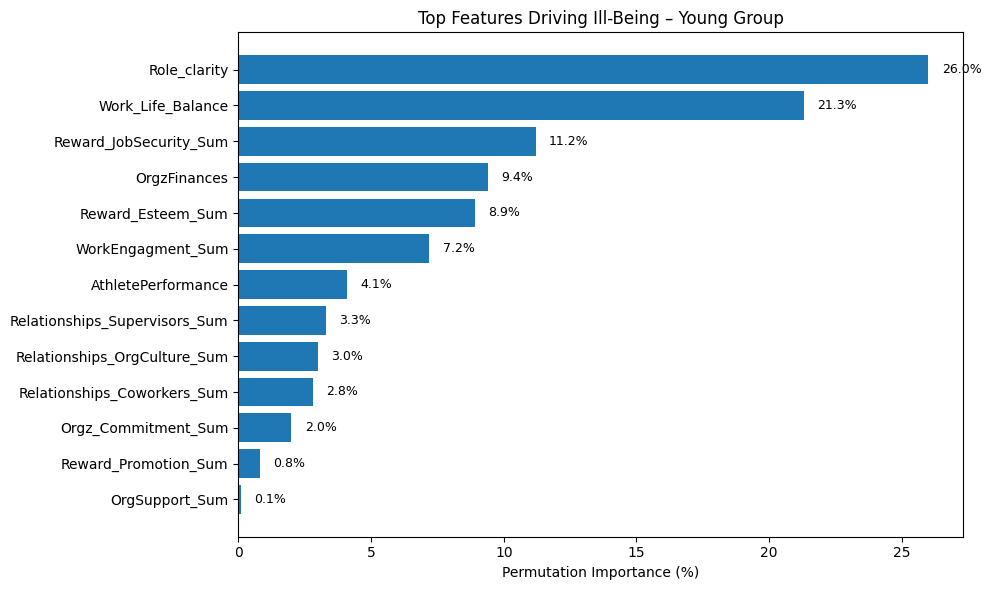

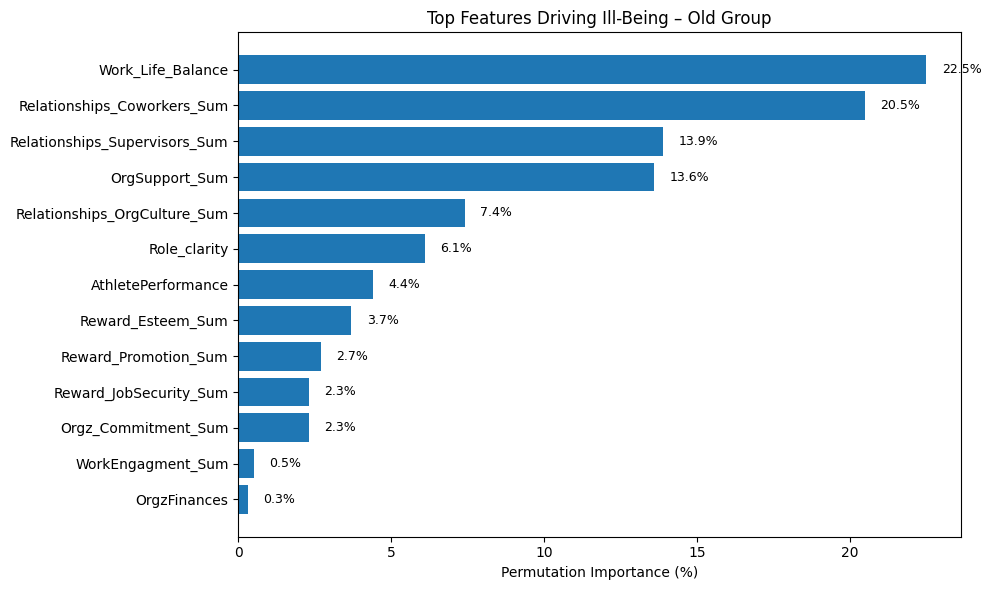

In [25]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X_with_age = X.copy()
X_with_age['Age'] = X_raw_source.loc[X_with_age.index, 'Age']

def map_age_group(age_str):
    if age_str in ['25-34', '35-44']:
        return 'Young'
    elif age_str in ['45-54', '55-64']:
        return 'Old'
    else:
        return 'Unknown'

X_with_age['AgeGroup'] = X_with_age['Age'].apply(map_age_group)

age_group_counts = X_with_age['AgeGroup'].value_counts()
print("\nCounts by AgeGroup:\n", age_group_counts)
      
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

group_results = {}

for group in ['Young', 'Old']:
    idx = X_with_age['AgeGroup'] == group
    X_group = X.loc[idx]
    y_group = y.loc[idx]

    if len(X_group) < 5:
        print(f"⚠️ Skipping {group} group due to too few samples ({len(X_group)})")
        continue

    group_pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('regressor', RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5))
    ])
    group_pipeline.fit(X_group, y_group)

    X_transformed_group = group_pipeline.named_steps['preprocess'].transform(X_group)

    group_feature_names = []
    group_feature_names.extend(numeric_cols)
    cat_transformer = group_pipeline.named_steps['preprocess'].named_transformers_.get('cat')
    if categorical_cols and cat_transformer and hasattr(cat_transformer, 'get_feature_names_out'):
        group_feature_names.extend(list(cat_transformer.get_feature_names_out(categorical_cols)))

    if len(group_feature_names) != X_transformed_group.shape[1]:
        group_feature_names = [f"feature_{i}" for i in range(X_transformed_group.shape[1])]

    perm_result = permutation_importance(
        group_pipeline.named_steps['regressor'],
        X_transformed_group,
        y_group,
        n_repeats=20,
        random_state=42
    )

    group_importance_df = pd.DataFrame({
        'feature': group_feature_names,
        'importance_mean': perm_result.importances_mean,
        'importance_std': perm_result.importances_std
    }).sort_values(by='importance_mean', ascending=False)

    total = group_importance_df['importance_mean'].sum()
    group_importance_df['importance_pct'] = (group_importance_df['importance_mean'] / total) * 100
    group_importance_df['importance_pct'] = group_importance_df['importance_pct'].round(1)

    group_results[group] = group_importance_df

total = group_importance_df['importance_mean'].sum()
group_importance_df['importance_pct'] = (group_importance_df['importance_mean'] / total) * 100
group_importance_df['importance_pct'] = group_importance_df['importance_pct'].round(1)

import matplotlib.pyplot as plt

for group, df in group_results.items():
    top_features = df.head(15).copy()
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(
        top_features['feature'][::-1],
        top_features['importance_pct'][::-1],
        color='tab:blue'
    )

    for bar, pct in zip(bars, top_features['importance_pct'][::-1]):
        if pct > 0:
            plt.text(
                bar.get_width() + 0.5,                   
                bar.get_y() + bar.get_height() / 2,
                f"{pct:.1f}%",
                va='center',
                fontsize=9
            )

    plt.xlabel("Permutation Importance (%)")
    plt.title(f"Top Features Driving Ill-Being – {group} Group")
    plt.tight_layout()
    plt.show()

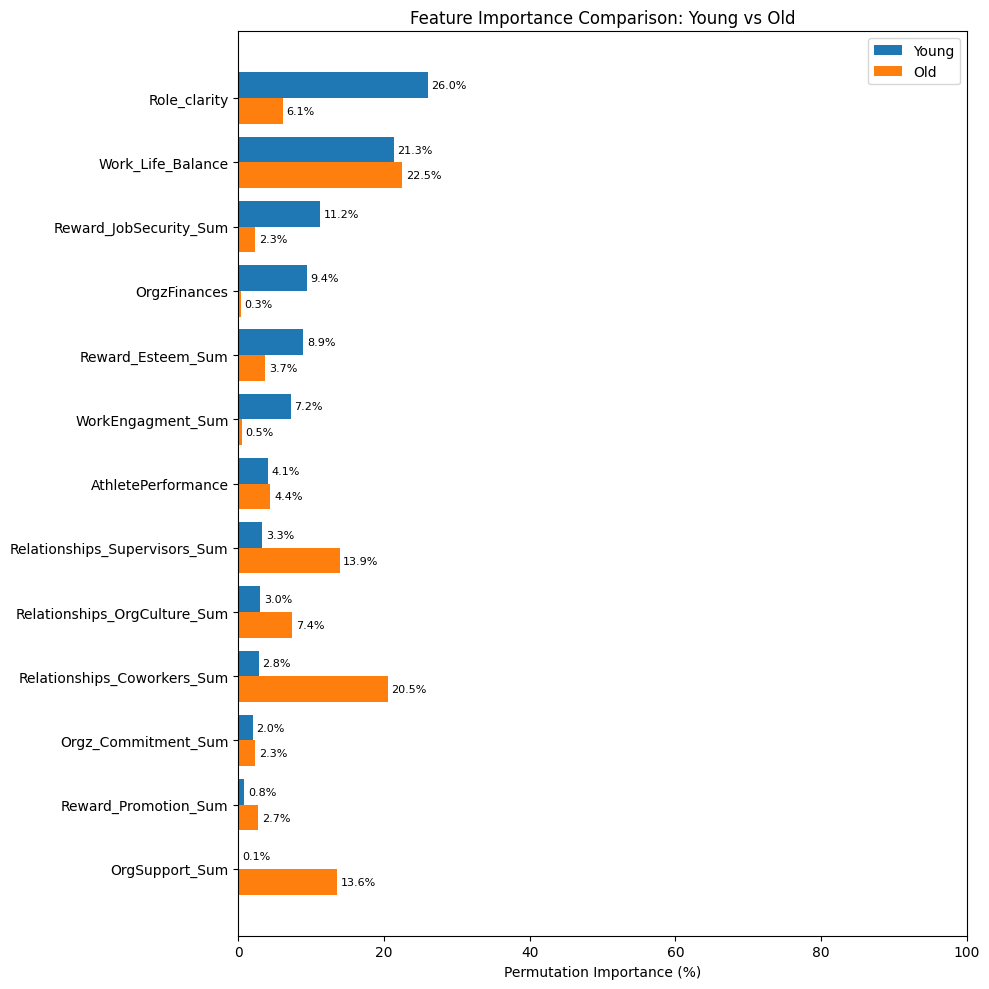

In [26]:
import matplotlib.pyplot as plt
import numpy as np

top_n = 15
young_df = group_results['Young'].set_index('feature')
old_df = group_results['Old'].set_index('feature')

combined_features = list(
    set(young_df.head(top_n).index).union(set(old_df.head(top_n).index))
)

combined_features = sorted(combined_features, key=lambda x: (
    young_df.loc[x]['importance_pct'] if x in young_df.index else 0 +
    old_df.loc[x]['importance_pct'] if x in old_df.index else 0
), reverse=True)

young_vals = [young_df.loc[f]['importance_pct'] if f in young_df.index else 0 for f in combined_features]
old_vals = [old_df.loc[f]['importance_pct'] if f in old_df.index else 0 for f in combined_features]

y_pos = np.arange(len(combined_features))
height = 0.4

plt.figure(figsize=(10, 10))
plt.barh(y_pos - height/2, young_vals, height, label='Young')
plt.barh(y_pos + height/2, old_vals, height, label='Old')

for i, (y, o) in enumerate(zip(young_vals, old_vals)):
    if y > 0:
        plt.text(y + 0.5, y_pos[i] - height/2, f"{y:.1f}%", va='center', fontsize=8)
    if o > 0:
        plt.text(o + 0.5, y_pos[i] + height/2, f"{o:.1f}%", va='center', fontsize=8)

plt.yticks(y_pos, combined_features)
plt.xlim(0,100)
plt.xlabel("Permutation Importance (%)")
plt.title("Feature Importance Comparison: Young vs Old")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Feature: Role_clarity
  Above Median IDs (3): [19, 28, 50]
  Below Median IDs (7): [5, 9, 12, 22, 27, 31, 41]

Feature: Work_Life_Balance
  Above Median IDs (6): [3, 19, 20, 36, 46, 50]
  Below Median IDs (13): [2, 5, 9, 12, 16, 24, 27, 31, 32, 35, 41, 45, 49]

Feature: Reward_JobSecurity_Sum
  Above Median IDs (7): [6, 20, 21, 28, 36, 37, 50]
  Below Median IDs (9): [5, 14, 17, 31, 32, 38, 44, 45, 49]

Feature: Reward_Esteem_Sum
  Above Median IDs (5): [21, 28, 29, 46, 50]
  Below Median IDs (3): [5, 31, 38]

Feature: Relationships_Supervisors_Sum
  Above Median IDs (6): [3, 20, 23, 28, 29, 46]
  Below Median IDs (5): [5, 16, 17, 38, 41]

Feature: WorkEngagment_Sum
  Above Median IDs (8): [19, 23, 25, 28, 36, 37, 46, 50]
  Below Median IDs (9): [5, 9, 12, 16, 27, 35, 41, 45, 49]

Feature: Relationships_OrgCulture_Sum
  Above Median IDs (6): [28, 29, 36, 37, 46, 50]
  Below Median IDs (7): [5, 12, 17, 27, 41, 45, 49]

Feature: OrgzFinances
  Above Median IDs (2): [20, 21]
  Below Medi

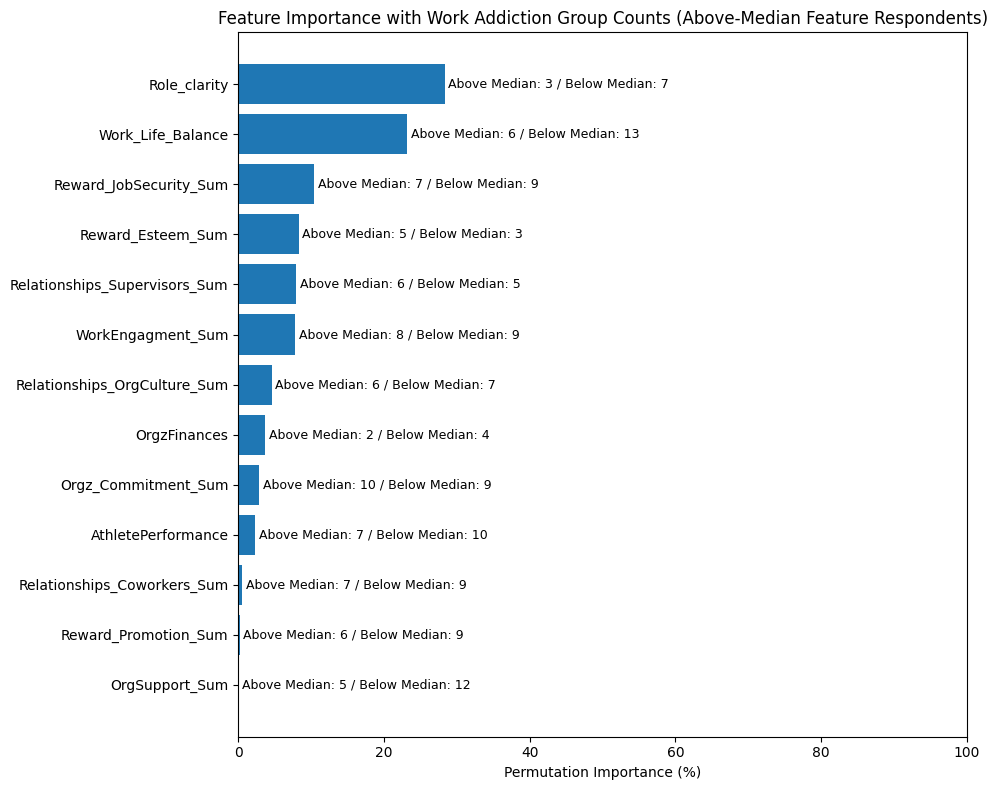

In [27]:

X_with_work_addiction = X.copy()
X_with_work_addiction['WorkAddiction_Sum'] = computeddata.loc[X.index, 'WorkAddiction_Sum']


X_with_ids_wa = X.copy()
X_with_ids_wa['Participant'] = X_raw_source.loc[X.index, 'Participant #']
X_with_ids_wa['WA_Group'] = pd.cut(
    X_with_work_addiction['WorkAddiction_Sum'],
    bins=[-float('inf'), X_with_work_addiction['WorkAddiction_Sum'].median(), float('inf')],
    labels=['Below Median', 'Above Median']
)

wa_groups = ['Above Median', 'Below Median']

top_n = 15
top_features = importances_df.head(top_n).copy()

wa_labels = []
ids_cols = {g: [] for g in wa_groups}

for feat in top_features['feature']:
    if feat in X.columns:
        feat_median = X[feat].median()
        above_median_feat = X[feat] > feat_median

        wa_median = X_with_work_addiction['WorkAddiction_Sum'].median()
        wa_above = X_with_work_addiction['WorkAddiction_Sum'] > wa_median
        group_counts = X_with_ids_wa.loc[above_median_feat, 'WA_Group'].value_counts()

        parts = [f"{g}: {group_counts.get(g, 0)}" for g in wa_groups if group_counts.get(g, 0) > 0]
        label = " / ".join(parts) if parts else "N/A"

        ids_this_feat = {}
        for g in wa_groups:
            ids_list = X_with_ids_wa.loc[
                above_median_feat & (X_with_ids_wa['WA_Group'] == g),
                'Participant'
            ].tolist()
            ids_this_feat[g] = ids_list
            ids_cols[g].append(ids_list)

        print(f"\nFeature: {feat}")
        for g in wa_groups:
            print(f"  {g} IDs ({len(ids_this_feat[g])}): {ids_this_feat[g]}")
    else:
        label = "N/A"
        for g in wa_groups:
            ids_cols[g].append([])

    wa_labels.append(label)

top_features['wa_group_label'] = wa_labels
for g in wa_groups:
    top_features[f'ids_wa_{g.lower().replace(" ", "_")}'] = ids_cols[g]

plt.figure(figsize=(10, 8))
bars = plt.barh(
    top_features['feature'][::-1],
    top_features['importance_pct'][::-1],
    color='tab:blue'
)

for bar, label in zip(bars, top_features['wa_group_label'][::-1]):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        label,
        va='center',
        fontsize=9,
        color='black'
    )

plt.xlim(0, 100)
plt.xlabel("Permutation Importance (%)")
plt.title("Feature Importance with Work Addiction Group Counts (Above-Median Feature Respondents)")
plt.tight_layout()
plt.show()

In [28]:

valid_rows = X.index  
df_valid = X_raw_source.loc[valid_rows].copy()

def map_coaching_group(val):
    if val in ['7 – 12 hours/week', '13 – 18 hours/week']:
        return 'Low'
    elif val in ['19 – 24 hours/week', '25 – 30 hours/week']:
        return 'Medium'
    elif val in ['31 – 36 hours/week', '37 or more hours/week']:
        return 'High'
    else:
        return 'Unknown'

def map_admin_group(val):
    if val in ['1 – 4 hours/week', '5 – 8 hours/week', '9 – 12 hours/week']:
        return 'Low'
    elif val in ['13 – 16 hours/week', '17 – 20 hours/week']:
        return 'Medium'
    elif val in ['21 or more hours/week']:
        return 'High'
    else:
        return 'Unknown'

df_valid['CoachGroup'] = df_valid['HrsCoaching'].apply(map_coaching_group)
df_valid['AdminGroup'] = df_valid['HrsAdmintrative'].apply(map_admin_group)

coach_counts = df_valid['CoachGroup'].value_counts()
admin_counts = df_valid['AdminGroup'].value_counts()

print(" Coaching Workload Group Counts (Valid Rows Only):")
print(coach_counts)

print("\n Admin Workload Group Counts (Valid Rows Only):")
print(admin_counts)

 Coaching Workload Group Counts (Valid Rows Only):
CoachGroup
Low       15
Medium    14
High      10
Name: count, dtype: int64

 Admin Workload Group Counts (Valid Rows Only):
AdminGroup
Medium    14
High      13
Low       12
Name: count, dtype: int64
